# Data cleaning

________________________________________________________________________________________________________________

**Filenames of scraped data**
- eye_products.json
- moisturizers_full.json
- treatments.json
- cleansers_full.json

__________________________________________________________________________________________________________________

## 0.0 Definitions

#### Variables
- brand
- product_name: product brand and name
- product_type: general category of product (i.e. essences, serums and treatments, moisturizers and creams, face wash and cleansers, eye creams and treatments, toners, exfoliators and peels)
- num_likes: number of likes
- rating: rating from 1-5 stars
- num_reviews: number of reviews received
- sensitive_type: whether product is suitable for sensitive skin
- combination_type: whether product is suitable for combination skin
- oily_type: whether product is suitable for oily skin
- normal_type: whether product is suitable for normal skin
- dry_type: whether product is suitable for dry skin
- clean_sephora: product does not contain the sulfates SLS and SLES, parabens, formaldehydes and formaldehyde-releasing agents, phthalates, mineral oil, retinylpalmitate, oxybenzone, coal tar, hydroquinone, triclosan, and triclocarban
- cruelty_free: not tested on animals
- vegan
- Acne/Blemishes, Anti-Aging, Dark Circles, Dark spots, Dryness, Dullness/Uneven Texture, Hair Dryness, Hydrating, Loss of firmness, Pores, Redness: whether or not the product targets these skin concerns
- num_excl_ingr: number of specific ingredients not used in the formulation of the product
- best_for_skintype: whether it is highlighted to be best for a specific skin type
- acids: notes if the product contains any of Hyaluronic Acid, Salicylic Acid, AHA/Glycolic Acid, Vitaminc C
- award: notes if the product is an allure winner or a community favorite
- pricepervol: price per oz
- highlighted_ingr: highlighted ingredients as noted in the 'about the product' section in Sephora
- clinical_results: whether clinical results have been noted in the 'about the product' section in Sephora
- formulation_type: whether it is a cream, serum, liquid, gel, oil, lotion or other
- richness: indicates whether the product is lightweight, normal or heavy
- ingr_list: list of ingredients used in the formula


#### Custom functions
- search_in_list --> Returns 1 if any item on the list contains the term and 0 otherwise (term - lowercase)
- extract_info2 --> Function can 1) search for term/phrase in the list and extracts the words immediately after the given phrase 2) Search for term/phrase and if found, this is added to the retrieved list 
- find_and_encode --> Takes in a dictionary containing term to be searched and the string to be returned if term is found in the list
- return_match --> Like a re.search function but fetches the exact match; none if no match 
- find_in_list --> Searches for pattern in the list and returns a list of the matches
- extract_next --> Searches for phrase in the list and extracts the next item on the list
- find_and_encode2 --> Takes in a dictionary containing the terms to be searched and the value to return if term is found; if not found, the default is returned 

__________________________________________________________________________________________________________________

## 1.0 Loading the files

In [1]:
#Import necessary libraries
import json 
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
#Adjusting settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

#Allow multiple execution of commands in one cell 
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
#Storing each raw json file in a dataframe 
with open('../data/raw_data/cleansers_full.json', 'r') as file:
    raw_data= json.load(file)
cleansers_raw=pd.DataFrame.from_dict(raw_data)

with open('../data/raw_data/eye_products.json', 'r') as file:
    raw_data= json.load(file)
eyeproducts_raw=pd.DataFrame.from_dict(raw_data)

with open('../data/raw_data/moisturizers_full.json', 'r') as file:
    raw_data= json.load(file)
moisturizers_raw=pd.DataFrame.from_dict(raw_data)

with open('../data/raw_data/treatments_full.json', 'r') as file:
    raw_data= json.load(file)
treatments_raw=pd.DataFrame.from_dict(raw_data)

In [4]:
#Inspecting the data
cleansers_raw.sample(5)
moisturizers_raw.sample(5)
eyeproducts_raw.sample(5)
treatments_raw.sample(5)

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights
401,CLINIQUE,Clarifying Lotion 3,"[What it is:, A gentle, oil-free exfoliating l...",https://www.sephora.com/product/coconut-melt-P...,Toners,cleansers,22K,https://www.sephora.com/productimages/sku/s129...,$17.50,6.7 oz/ 200 mL,"[Water, Alcohol Denat., Salicylic Acid, Hamame...",4.5 stars,898,[]
255,SEPHORA COLLECTION,Waterproof Eye Makeup Remover,"[What it is:, A waterproof eye makeup remover ...",https://www.sephora.com/product/ultra-repair-w...,Makeup Removers,cleansers,75.4K,https://www.sephora.com/productimages/sku/s125...,$11.00,4.2 oz / 125 mL,[ -HydroSenn+: Moisturizes intensely; forms a ...,4.5 stars,3.8K,[]
10,Glow Recipe,Blueberry Bounce Gentle Cleanser,"[What it is: , A gentle cleanser and makeup r...",https://www.sephora.com/product/polished-rice-...,Face Wash & Cleansers,cleansers,44.7K,https://www.sephora.com/productimages/sku/s213...,$34.00,5.41 oz/ 160 mL,[ -Blueberry Extract: Packed with antioxidants...,4 stars,799,"[Hyaluronic Acid, AHA/Glycolic Acid, Good for:..."
28,Clarins,Soothing Toning Lotion,"[What it is: , A refreshing plant-based and a...",https://www.sephora.com/product/water-drench-h...,Toners,cleansers,388,https://www.sephora.com/productimages/sku/s243...,$27.00,6.7 oz/ 200 mL,[-Microbiote Complex: Balances the skin’s natu...,3 stars,2,"[Good for: Redness, Best for Dry Skin, Recycla..."
15,The INKEY List,Salicylic Acid Acne + Pore Cleanser,"[What it is: , A lightly-foaming cleanser that...",https://www.sephora.com/product/the-cleansing-...,Face Wash & Cleansers,cleansers,74.9K,https://www.sephora.com/productimages/sku/s221...,$9.99,5 oz/ 150 mL,[-Salicylic Acid 2%: Helps to gently exfoliate...,4.5 stars,791,"[Clean at Sephora, Community Favorite, Salicyl..."


,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights
64,Origins,Plantscription™ Retinol Night Moisturizer,"[What it is: , A nourishing overnight moistur...",https://www.sephora.com/product/royal-oil-100-...,Moisturizers,moisturizers,6.9K,https://www.sephora.com/productimages/sku/s221...,$64.00,1 oz/ 30 mL,[-High-Grade Retinol: The gold standard in the...,4.5 stars,30,"[Clean at Sephora, Retinol, Good for: Dark spo..."
359,Lancôme,Rénergie Lift Multi-Action Lifting & Firming Duo,"[What it is: , A visibly lifting and firming ...",https://www.sephora.com/product/the-essential-...,Value & Gift Sets,moisturizers,1.8K,https://www.sephora.com/productimages/sku/s213...,$170.00,None,[Rénergie Lift Multi-Action Sunscreen Broad S...,5 stars,None,[]
422,rms beauty,Beauty Oil,"[What it is: , A potent blend of supercharged ...",https://www.sephora.com/product/clinique-id-yo...,Face Oils,moisturizers,11.9K,https://www.sephora.com/productimages/sku/s183...,$78.00,1 oz/ 30 mL,"[ -Jojoba Oil: Rich in antioxidants, jojoba qu...",4.5 stars,78,"[Hydrating, Good for: Dullness/Uneven Texture,..."
467,L'Occitane,Immortelle Divine Cream,"[What it is:, An exceptional antiaging cream t...",https://www.sephora.com/product/immortelle-div...,Moisturizers,moisturizers,5.7K,https://www.sephora.com/productimages/sku/s163...,$110.00,1.7 oz/ 50 mL,"[ -Immortelle Essential Oil, -Hyaluronic Acid,...",4 stars,156,"[Cream Formula, Good for: Anti-Aging, Good for..."
479,CLINIQUE,Clinique Smart Clinical™ MD Multi-Dimensional ...,"[What it is: , \nA tightening gel-cream and a...",https://www.sephora.com/product/laura-mercier-...,Moisturizers,moisturizers,1.7K,https://www.sephora.com/productimages/sku/s224...,$69.00,1.7 oz/ 50 mL,[ -Hyaluronic Acid: Plumps and hydrates skin. ...,3 stars,6,[]


,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights
141,The INKEY List,Retinol Eye Cream,"[What it is: , A nighttime eye cream formulat...",https://www.sephora.com/product/ferulic-retino...,Eye Creams & Treatments,eye products,31.1K,https://www.sephora.com/productimages/sku/s233...,$9.99,0.5 oz/ 15 mL,[ -Vitalease (Retinol): Stabilized retinoid co...,4 stars,414,"[Clean at Sephora, Retinol, Good for: Anti-Agi..."
26,Perricone MD,No Makeup Concealer Broad Spectrum SPF 20,"[What it is: , A multitasking concealer that i...",https://www.sephora.com/product/l-occitane-imm...,Concealer,eye products,9K,https://www.sephora.com/productimages/sku/s221...,$35.00,None,"[Water, Dimethicone, Cyclopentasiloxane, Butyl...",4 stars,187,[]
177,Dior,Hydra Life Cooling Hydration Sorbet Eye Gel,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/advanced-night...,Eye Creams & Treatments,eye products,3.9K,https://www.sephora.com/productimages/sku/s205...,$55.00,0.5 oz/ 15 mL,"[Aqua (Water), Glycerin, Centaurea Cyanus Flow...",3.5 stars,28,[]
138,Shiseido,Benefiance WrinkleResist24 Pure Retinol Expres...,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/ferulic-retino...,Eye Masks,eye products,61.6K,https://www.sephora.com/productimages/sku/s159...,$70.00,3 Packettes x 2 Sheets,[ -Pure Retinol Micro-infusion Technology: Vis...,4.5 stars,451,"[allure 2020 Best of Beauty Award Winner , Ret..."
36,Dr. Zenovia Skincare,Retinol Recovery Eye Cream,"[What it is: , A cream clinically formulated ...",https://www.sephora.com/product/the-quench-eye...,Eye Creams & Treatments,eye products,293,https://www.sephora.com/productimages/sku/s239...,$64.00,0.5 oz/ 15 mL,[ -All-Trans-Retinol Technology: Supports coll...,4 stars,98,"[Best for Normal Skin, Good for: Dark Circles,..."


,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights
46,Dr. Brandt Skincare,2% Retinol Complex Serum,"[What it is: , A potent, time-released serum ...",https://www.sephora.com/product/youth-or-dare-...,Face Serums,treatments,11.3K,https://www.sephora.com/productimages/sku/s192...,$69.00,1 oz/ 30 mL,[ -Two-Percent Retinol Complex: Improves the l...,3.5 stars,94,[]
22,LANCER Skincare,The Method: Polish Oily-Congested Skin,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/time-in-bottle...,Exfoliators,treatments,7.7K,https://www.sephora.com/productimages/sku/s174...,$75.00,4.2 oz,"[Water, Sodium C14-16 Olefin Sulfonate, Acryla...",4.5 stars,41,"[Best for Oily, Combo, Normal Skin, Good for: ..."
244,Peter Thomas Roth,Peptide 21® Wrinkle Resist Serum,"[What it is: , A wrinkle-fighting serum with ...",https://www.sephora.com/product/the-treatment-...,Face Serums,treatments,5.5K,https://www.sephora.com/productimages/sku/s217...,$125.00,1 oz/ 30 mL,[ -73% Peptide and Neuropeptide Complex: Helps...,4.5 stars,553,[]
436,Dr. Dennis Gross Skincare,Alpha Beta® Pore Perfecting & Refining Serum,"[What it is: , A silicone-free pore treatment...",https://www.sephora.com/product/lightstim-for-...,Face Serums,treatments,18.9K,https://www.sephora.com/productimages/sku/s227...,$65.00,1 oz/ 30 mL,[-Agarikon Mushroom Extract: Helps reduce shin...,4.5 stars,1.5K,"[AHA/Glycolic Acid, Salicylic Acid, Best for O..."
520,CLINIQUE,Acne Solutions™ Cleansing Gel,"[What it is: , A refreshing cleanser with two...",https://www.sephora.com/product/eradikate-mask...,Blemish & Acne Treatments,treatments,6.1K,https://www.sephora.com/productimages/sku/s167...,$22.50,4.2 oz/ 125 mL,[ -Salicylic Acid and Acetyl Glucosamine: Help...,4 stars,90,[]


## 2.0 Pre-processing the features

### Summary of steps taken:

1) Created new column to include both brand and product name

2) Inspected for missing values and deleted rows where appropriate

3) Removed 'stars' from rating and converted column into numeric type

4) Remove currency sign from price and converted into numeric type

5) Translated both number of likes and number of reviews into digits and converted into numeric data 

6) Created new features based on skin type the product was compatible with. This was derived from the 'about the product section'. (New columns created containing 1 or 0 for each of normal, combination, oily, dry, sensitive)

7) Created new feature based on highlights 

8) Create a new (uniform) feature for 'size'

9) Derive a feature for price adjusted for the size or volume of the product 

10) Create new feature based on highlighted ingredients

11) Create a new feature capturing whether clinical results are published in the about section

12) Extract formulation type for each ingredient and capture this in a separate feature(s)

**1) Created new column to include both brand and product name**

In [5]:
#Creating new column for full product name 
cleansers_raw['product_name']=cleansers_raw['brand']+' '+cleansers_raw['name']
treatments_raw['product_name']=treatments_raw['brand']+ ' '+ treatments_raw['name']
moisturizers_raw['product_name']=moisturizers_raw['brand']+' ' + moisturizers_raw['name']
eyeproducts_raw['product_name']=eyeproducts_raw['brand']+ ' '+eyeproducts_raw['name']

**2) Inspected for missing values and deleted rows where appropriate**

In [6]:
#Inspect missing values 

#see total number of items
cleansers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409 entries, 0 to 408
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              407 non-null    object
 1   name               407 non-null    object
 2   about the product  409 non-null    object
 3   weblink            409 non-null    object
 4   sub_category       407 non-null    object
 5   main_category      409 non-null    object
 6   num_likes          407 non-null    object
 7   img_link           409 non-null    object
 8   price              403 non-null    object
 9   size               363 non-null    object
 10  ingredients        409 non-null    object
 11  rating             409 non-null    object
 12  num_reviews        402 non-null    object
 13  highlights         409 non-null    object
 14  product_name       407 non-null    object
dtypes: object(15)
memory usage: 48.1+ KB


In [7]:
cleansers_raw[cleansers_raw['size'].isnull()]

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name
1,Drunk Elephant,Slaai™ Makeup-Melting Butter Cleanser,"[What it is: , An innovative cleansing balm t...",https://www.sephora.com/product/cleansing-exfo...,Face Wash & Cleansers,cleansers,66.6K,https://www.sephora.com/productimages/sku/s217...,$34.00,None,[ -Nourishing Fruit Salad Blend: A mix of non-...,4 stars,1.3K,[allure 2019 Best of Beauty Award Winner: Clea...,Drunk Elephant Slaai™ Makeup-Melting Butter C...
6,SEPHORA COLLECTION,Cleansing & Exfoliating Wipes,"[What it is: , A collection of cleansing and ...",https://www.sephora.com/product/cleansing-exfo...,Face Wipes,cleansers,258.6K,https://www.sephora.com/productimages/sku/s180...,$8.00,None,"[ -Coconut Water Extract.\n, \n, Water, Capry...",4.5 stars,3.7K,"[Best for Dry, Combo, Normal Skin, Good for: D...",SEPHORA COLLECTION Cleansing & Exfoliating Wipes
12,Tatcha,The Rice Polish Foaming Enzyme Powder,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/polished-rice-...,Exfoliators,cleansers,133.2K,https://www.sephora.com/productimages/sku/s212...,$65.00,None,[ -Japanese Rice Bran: Gently exfoliates to so...,4.5 stars,1.6K,"[Clean at Sephora, Good for: Pores , Good for:...",Tatcha The Rice Polish Foaming Enzyme Powder
36,Estée Lauder,Nutritious Super-Pomegranate Radiant Energy Lo...,"[What it is: , A rich, cushioning treatment lo...",https://www.sephora.com/product/bi-facil-face-...,Toners,cleansers,5.6K,https://www.sephora.com/productimages/sku/s218...,$58.00,None,"[Water\Aqua\Eau, Alcohol Denat., Glycerin, Dip...",4 stars,10,[],Estée Lauder Nutritious Super-Pomegranate Radi...
48,Clarins,Instant Eye Makeup Remover,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/instant-eye-ma...,Makeup Removers,cleansers,5K,https://www.sephora.com/productimages/sku/s153...,$30.00,None,[ -Volatile Ultra-fine Oils: Remove heavy or w...,4.5 stars,148,[],Clarins Instant Eye Makeup Remover
57,Drunk Elephant,Baby Bar Travel Duo with Case,"[What it is: , A baby Juju Bar and Pekee Bar™...",https://www.sephora.com/product/one-size-go-of...,Value & Gift Sets,cleansers,17.6K,https://www.sephora.com/productimages/sku/s217...,$22.00,None,"[ -Virgin Marula Oil: Hydrates, protects, heal...",4.5 stars,114,"[Clean at Sephora, Best for Dry, Combo, Normal...",Drunk Elephant Baby Bar Travel Duo with Case
68,SEPHORA COLLECTION,Hemp Cleansing Wipes,"[What it is: , A cleansing wipe that is formu...",https://www.sephora.com/product/laura-mercier-...,Face Wipes,cleansers,0,https://www.sephora.com/productimages/sku/s223...,$8.00,None,[-Hemp from Natural Origin: Provides the look ...,4 stars,10,"[Best for Dry, Combo, Normal Skin, Good for: D...",SEPHORA COLLECTION Hemp Cleansing Wipes
74,MILK MAKEUP,Matcha Cleanser,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/mario-badescu-...,Face Wash & Cleansers,cleansers,18.6K,https://www.sephora.com/productimages/sku/s191...,$30.00,None,"[Water, Butylene Glycol, Sodium Stearate, Bis-...",4 stars,182,"[Clean at Sephora, Good for: Redness]",MILK MAKEUP Matcha Cleanser
77,Clarins,Hydrating Gentle Foaming Cleanser,"[What it is: , A creamy, rinse-off foaming cl...",https://www.sephora.com/product/mario-badescu-...,Face Wash & Cleansers,cleansers,115,https://www.sephora.com/productimages/sku/s244...,$27.00,None,[-Saponaria Balm Extracts: Natural properties ...,1 star,1,"[Cream Formula, Best for Dry Skin, Without Min...",Clarins Hydrating Gentle Foaming Cleanser
80,Shiseido,Instant Eye And Lip Makeup Remover,"[What it is:, A gentle, dual-phase formula to ...",https://www.sephora.com/product/fresh-pressed-...,Makeup Removers,cleansers,4.3K,https://www.sephora.com/productimages/sku/s164...,$30.00,None,"[Water, Cyclomethicone, Butylene Glycol, Sd Al...",4.5 stars,90,[],Shiseido Instant Eye And Lip Makeup Remover


In [8]:
treatments_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 578 entries, 0 to 577
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              578 non-null    object
 1   name               578 non-null    object
 2   about the product  578 non-null    object
 3   weblink            578 non-null    object
 4   sub_category       578 non-null    object
 5   main_category      578 non-null    object
 6   num_likes          578 non-null    object
 7   img_link           578 non-null    object
 8   price              573 non-null    object
 9   size               498 non-null    object
 10  ingredients        578 non-null    object
 11  rating             578 non-null    object
 12  num_reviews        572 non-null    object
 13  highlights         578 non-null    object
 14  product_name       578 non-null    object
dtypes: object(15)
memory usage: 67.9+ KB


In [9]:
treatments_raw[treatments_raw['size'].isnull()]

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name
13,fresh,Umbrian Clay Pore Purifying Face Mask,"[What it is: , A mineral-rich clay mask and f...",https://www.sephora.com/product/b-oil-P442757?...,Face Masks,treatments,100.7K,https://www.sephora.com/productimages/sku/s182...,$58.00,None,"[ -Umbrian Clay: Works to help balance, purify...",4.5 stars,875,[],fresh Umbrian Clay Pore Purifying Face Mask
14,First Aid Beauty,Ultra Repair® Hydrating Serum,"[What it is: , A water-based serum that gives...",https://www.sephora.com/product/b-oil-P442757?...,Face Serums,treatments,50.2K,https://www.sephora.com/productimages/sku/s220...,$38.00,None,[-Colloidal Oatmeal: Helps calm and soothe dry...,4 stars,671,"[Fragrance Free, Cruelty-Free, Best for Dry Sk...",First Aid Beauty Ultra Repair® Hydrating Serum
18,CLINIQUE,"Clean Skin, Fresh Start Acne Solutions Set","[What it is: , A set of fast-acting formulas ...",https://www.sephora.com/product/time-in-bottle...,Value & Gift Sets,treatments,920,https://www.sephora.com/productimages/sku/s242...,$19.50,None,[-Salicylic Acid and Acetyl Glucosamine: Remov...,3 stars,3,[],"CLINIQUE Clean Skin, Fresh Start Acne Solution..."
19,Perricone MD,Vitamin C Ester Brightening Serum,"[Which skin type is it good for?, \n, ✔ Normal...",https://www.sephora.com/product/time-in-bottle...,Face Serums,treatments,14K,https://www.sephora.com/productimages/sku/s212...,$69.00,None,"[ -Vitamin C Ester: Brightens and smooths.\n,...",4.5 stars,439,"[Best for Dry, Combo, Normal Skin, Good for: D...",Perricone MD Vitamin C Ester Brightening Serum
35,Murad,Rapid Collagen Infusion,"[What it is:, \n, An antiaging treatment that ...",https://www.sephora.com/product/ningaloo-coppe...,Face Serums,treatments,8.3K,https://www.sephora.com/productimages/sku/s221...,$79.00,None,[ -Collagen Support Complex: Supports natural...,4 stars,121,[],Murad Rapid Collagen Infusion
49,SEPHORA COLLECTION,Clarifying Lotion,"[What it is: , A 90 percent natural-ingredien...",https://www.sephora.com/product/youth-or-dare-...,Blemish & Acne Treatments,treatments,3.5K,https://www.sephora.com/productimages/sku/s225...,$16.00,None,[ -Natural-Origin Salicylic Acid: Exfoliates. ...,3.5 stars,23,"[Clean at Sephora, Vegan]",SEPHORA COLLECTION Clarifying Lotion
56,Jack Black,Power Peel Multi-Acid Resurfacing Pads,"[What it is:, \n\n, A high-potency formula tha...",https://www.sephora.com/product/superserum-6-a...,Moisturizer & Treatments,treatments,5.3K,https://www.sephora.com/productimages/sku/s138...,$38.00,None,"[Water, Alcohol Denat., Butylene Glycol, Glyco...",4.5 stars,51,[],Jack Black Power Peel Multi-Acid Resurfacing Pads
57,Dr. Jart+,Focuspot™ Dark Circle Micro Tip™ Patch,"[What it is: , A set of self-dissolving micro ...",https://www.sephora.com/product/superserum-6-a...,Face Serums,treatments,0,https://www.sephora.com/productimages/sku/s219...,$18.00,None,"[Sodium Hyaluronate, Glycerin, Oxidized Glutat...",3 stars,107,[],Dr. Jart+ Focuspot™ Dark Circle Micro Tip™ Patch
74,HUM Nutrition,Big Chill™ Stress Management Supplement,"[Beauty Benefit:, Stress Relief , What it is:...",https://www.sephora.com/product/kx-active-conc...,Beauty Supplements,treatments,14K,https://www.sephora.com/productimages/sku/s223...,$20.00,None,[-Rhodiola Rosea: Supports adrenal balance to ...,4.5 stars,68,[],HUM Nutrition Big Chill™ Stress Management Sup...
84,Kiehl's Since 1851,Clearly Corrective Accelerated Clarity & Renew...,"[What it is: , A two-week ampoule brightening...",https://www.sephora.com/product/clinique-id-yo...,Face Serums,treatments,774,https://www.sephora.com/productimages/sku/s232...,$95.00,None,[-Activated C: Visibly brightens skin and redu...,4 stars,145,[],Kiehl's Since 1851 Clearly Corrective Accelera...


In [10]:
eyeproducts_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220 entries, 0 to 219
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              220 non-null    object
 1   name               220 non-null    object
 2   about the product  220 non-null    object
 3   weblink            220 non-null    object
 4   sub_category       220 non-null    object
 5   main_category      220 non-null    object
 6   num_likes          220 non-null    object
 7   img_link           220 non-null    object
 8   price              216 non-null    object
 9   size               190 non-null    object
 10  ingredients        220 non-null    object
 11  rating             220 non-null    object
 12  num_reviews        216 non-null    object
 13  highlights         220 non-null    object
 14  product_name       220 non-null    object
dtypes: object(15)
memory usage: 25.9+ KB


In [11]:
eyeproducts_raw[eyeproducts_raw['size'].isnull()]

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name
0,Peace Out,Retinol Eye Stick,"[What it is: , A concentrated serum balm that...",https://www.sephora.com/product/the-pearl-tint...,Eye Creams & Treatments,eye products,73.4K,https://www.sephora.com/productimages/sku/s241...,$28.00,None,[-Encapsulated Retinol: Softens the look of fi...,4.5 stars,495,"[Retinol, Good for: Anti-Aging, Good for: Loss...",Peace Out Retinol Eye Stick
3,Wander Beauty,Baggage Claim Eye Masks,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/the-pearl-tint...,Eye Masks,eye products,32.8K,https://www.sephora.com/productimages/sku/s215...,$25.00,None,[-Peptides: Help to improve the texture and to...,4 stars,446,"[Cruelty-Free, allure 2020 Best of Beauty Awar...",Wander Beauty Baggage Claim Eye Masks
6,Tatcha,The Pearl Tinted Eye Illuminating Treatment,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/the-pearl-tint...,Eye Creams & Treatments,eye products,69.6K,https://www.sephora.com/productimages/sku/s207...,$48.00,None,[ -Liquid Extract from Akoya Pearls: A natural...,4 stars,1.1K,"[Clean at Sephora, Community Favorite, Good fo...",Tatcha The Pearl Tinted Eye Illuminating Treat...
8,IT Cosmetics,Your Hydrating Moisturizer and Eye Cream Set,"[What it is: , An essential duo set that cont...",https://www.sephora.com/product/maracuja-c-bri...,Value & Gift Sets,eye products,460,https://www.sephora.com/productimages/sku/s244...,$65.00,None,"[-Ceramides: Help support the skin barrier, ke...",4 stars,None,[],IT Cosmetics Your Hydrating Moisturizer and Ey...
21,KNC Beauty,All Natural Retinol Infused Eye Mask- 5 Pack,"[What it is: , A eye mask set that will give ...",https://www.sephora.com/product/l-occitane-imm...,Eye Masks,eye products,6.2K,https://www.sephora.com/productimages/sku/s222...,$25.00,None,"[ -Collagen: Helps plum., -Hyaluronic acid: He...",4 stars,21,"[allure 2020 Best of Beauty Award Winner , Goo...",KNC Beauty All Natural Retinol Infused Eye Mas...
25,Anthony,High Performance Continuous Moisture Eye Cream,"[What it is:, \n, An advanced, time-released,...",https://www.sephora.com/product/l-occitane-imm...,Eye Cream,eye products,2.9K,https://www.sephora.com/productimages/sku/s160...,$40.00,None,[ -Shea Butter: Helps reduce the appearance of...,4 stars,38,[],Anthony High Performance Continuous Moisture E...
26,Perricone MD,No Makeup Concealer Broad Spectrum SPF 20,"[What it is: , A multitasking concealer that i...",https://www.sephora.com/product/l-occitane-imm...,Concealer,eye products,9K,https://www.sephora.com/productimages/sku/s221...,$35.00,None,"[Water, Dimethicone, Cyclopentasiloxane, Butyl...",4 stars,187,[],Perricone MD No Makeup Concealer Broad Spectru...
33,REN Clean Skincare,Vita Mineral™ Active 7 Eye Gel,"[What it is: , A light, vegan, cooling eye ge...",https://www.sephora.com/product/sobel-skin-rx-...,Eye Creams & Treatments,eye products,3.7K,https://www.sephora.com/productimages/sku/s211...,$36.00,None,"[ -Wild Rumex: Illuminates the eye area. , -Ar...",3.5 stars,150,"[Clean at Sephora, Good for: Dryness, Good for...",REN Clean Skincare Vita Mineral™ Active 7 Eye ...
37,Clarins,Eye Contour Gel,"[What it is:, A cooling eye gel to minimize pu...",https://www.sephora.com/product/the-quench-eye...,Eye Creams & Treatments,eye products,3.1K,https://www.sephora.com/productimages/sku/s137...,$43.00,None,[ -Certified Organic Ginkgo Biloba: Minimizes ...,4 stars,102,[],Clarins Eye Contour Gel
38,BeautyBio,GloPRO® EYE MicroTip™ Attachment Head,"[What it is: , An attachment head that is des...",https://www.sephora.com/product/the-quench-eye...,Anti-Aging,eye products,4.3K,https://www.sephora.com/productimages/sku/s216...,$35.00,None,"[Suggested Usage:, -Use GloPRO® EYE in the PM ...",3 stars,6,[],BeautyBio GloPRO® EYE MicroTip™ Attachment Head


In [12]:
moisturizers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              645 non-null    object
 1   name               645 non-null    object
 2   about the product  645 non-null    object
 3   weblink            645 non-null    object
 4   sub_category       645 non-null    object
 5   main_category      645 non-null    object
 6   num_likes          645 non-null    object
 7   img_link           645 non-null    object
 8   price              642 non-null    object
 9   size               569 non-null    object
 10  ingredients        645 non-null    object
 11  rating             645 non-null    object
 12  num_reviews        635 non-null    object
 13  highlights         645 non-null    object
 14  product_name       645 non-null    object
dtypes: object(15)
memory usage: 75.7+ KB


In [13]:
moisturizers_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 645 entries, 0 to 644
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   brand              645 non-null    object
 1   name               645 non-null    object
 2   about the product  645 non-null    object
 3   weblink            645 non-null    object
 4   sub_category       645 non-null    object
 5   main_category      645 non-null    object
 6   num_likes          645 non-null    object
 7   img_link           645 non-null    object
 8   price              642 non-null    object
 9   size               569 non-null    object
 10  ingredients        645 non-null    object
 11  rating             645 non-null    object
 12  num_reviews        635 non-null    object
 13  highlights         645 non-null    object
 14  product_name       645 non-null    object
dtypes: object(15)
memory usage: 75.7+ KB


In [14]:
moisturizers_raw[moisturizers_raw['size'].isnull()]

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name
8,IT Cosmetics,CC+ Cream Illumination with SPF 50+,"[What it is: , A color-correcting, full-covera...",https://www.sephora.com/product/jlo-beauty-tha...,BB & CC Cream,moisturizers,60K,https://www.sephora.com/productimages/sku/s186...,$39.50,None,[ -Collagen: Enhances visible elasticity for a...,4 stars,732,"[Full Coverage, SPF, Cream Formula, Radiant Fi...",IT Cosmetics CC+ Cream Illumination with SPF 50+
15,Murad,Nutrient-Charged Water Gel,"[What it is: , A lightweight, oil-free gel mo...",https://www.sephora.com/product/face-finishing...,Moisturizers,moisturizers,18.5K,https://www.sephora.com/productimages/sku/s221...,$62.00,None,"[-Vitamins B3, B5, B6, B9, and E: Alleviate dr...",4.5 stars,611,"[Good for: Dullness/Uneven Texture, Good for: ...",Murad Nutrient-Charged Water Gel
20,Briogeo,B. Well Organic + Australian 100% Tea Tree Sk...,"[What it is: , A 100 percent pure oil with pot...",https://www.sephora.com/product/b-well-organic...,Hair Oil,moisturizers,20.3K,https://www.sephora.com/productimages/sku/s218...,$32.00,None,[ -Melaleuca Alternifolia (Tea Tree) Leaf Oil:...,5 stars,155,"[Clean at Sephora, Good for: Flaky/Dry Scalp, ...",Briogeo B. Well Organic + Australian 100% Tea...
23,Briogeo,B. Well Organic + Cold-Pressed 100% Castor Oil,"[What it is: , A cold-pressed, organic*, fair-...",https://www.sephora.com/product/b-well-organic...,Hair Oil,moisturizers,34K,https://www.sephora.com/productimages/sku/s218...,$26.00,None,[ -100% Organic* Cold-Pressed Castor Oil: Oil ...,4.5 stars,269,"[Clean at Sephora, Good for: Dryness, Fragranc...",Briogeo B. Well Organic + Cold-Pressed 100% Ca...
35,bareMinerals,Prime Time™ BB Tinted Primer Broad Spectrum S...,"[Skin type:, , ✔ Combination , ✔ Oily, Wha...",https://www.sephora.com/product/bienfait-multi...,BB & CC Cream,moisturizers,20.2K,https://www.sephora.com/productimages/sku/s157...,$27.00,None,"[Cyclopentasiloxane, Dimethicone Crosspolymer,...",4 stars,334,[],bareMinerals Prime Time™ BB Tinted Primer Bro...
40,Dr. Brandt Skincare,Hydro Biotic™ Recovery Sleeping Mask,"[What it is: , A leave-on mask that works ove...",https://www.sephora.com/product/hyaluronic-mar...,Face Masks,moisturizers,16.5K,https://www.sephora.com/productimages/sku/s202...,$52.00,None,[ -Biotic Balancing Complex: Maintains skin's ...,4.5 stars,1.1K,"[Best for Dry, Combo, Normal Skin, Good for: D...",Dr. Brandt Skincare Hydro Biotic™ Recovery Sle...
47,CLINIQUE,Acne Solutions™ BB Cream SPF 40,"[What it is: , A mattifying BB Cream specific...",https://www.sephora.com/product/kate-somervill...,BB & CC Cream,moisturizers,43.5K,https://www.sephora.com/productimages/sku/s167...,$39.50,None,[ -Mica and Titanium Dioxide: Light-diffusing ...,4 stars,696,[],CLINIQUE Acne Solutions™ BB Cream SPF 40
56,Dr. Jart+,Black Label Detox BB Beauty Balm,"[What it is: , A beauty balm that supports ant...",https://www.sephora.com/product/goop-goopgenes...,BB & CC Cream,moisturizers,28.4K,https://www.sephora.com/productimages/sku/s142...,$36.00,None,"[Water, Cyclopentasiloxane, Phenyl Trimethicon...",4 stars,1.5K,[],Dr. Jart+ Black Label Detox BB Beauty Balm
81,Dior,Capture Totale Intensive Night Restorative Crème,"[What it is:, A face cream that works to comba...",https://www.sephora.com/product/double-duty-fa...,Moisturizers,moisturizers,3.6K,https://www.sephora.com/productimages/sku/s163...,$175.00,None,"[Aqua (Water), Glycerin, Decyl Oleate, Hydroge...",4.5 stars,37,"[Good for: Anti-Aging, Good for: Dark spots, G...",Dior Capture Totale Intensive Night Restorativ...
119,Murad,Essential-C Day Moisture Broad Spectrum SPF 30...,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/goodnight-glow...,Moisturizers,moisturizers,19.5K,https://www.sephora.com/productimages/sku/s120...,$65.00,None,"[ -Avobenzone 3%\n, -Homosalate 6.5%\n, -Octin...",4 stars,

Most of the rows with no associated 'size' are related to masks, supplements, devices, peels, make-up removers, gift sets, eye masks, eye gels, massager/rollers, etc. so these can be deleted as they are not the main focus of the study.

In [15]:
print('Initial shape: ', cleansers_raw.shape)
cleansers_raw.drop(cleansers_raw[cleansers_raw['size'].isnull()].index, inplace=True)
print('After deletion: ', cleansers_raw.shape)

Initial shape:  (409, 15)
After deletion:  (363, 15)


In [16]:
print('Initial shape: ', treatments_raw.shape)
treatments_raw.drop(treatments_raw[treatments_raw['size'].isnull()].index, inplace=True)
print('After deletion: ', treatments_raw.shape)

Initial shape:  (578, 15)
After deletion:  (498, 15)


In [17]:
print('Initial shape: ', eyeproducts_raw.shape)
eyeproducts_raw.drop(eyeproducts_raw[eyeproducts_raw['size'].isnull()].index, inplace=True)
print('After deletion: ', eyeproducts_raw.shape)

Initial shape:  (220, 15)
After deletion:  (190, 15)


In [18]:
print('Initial shape: ', moisturizers_raw.shape)
moisturizers_raw.drop(moisturizers_raw[moisturizers_raw['size'].isnull()].index, inplace=True)
print('After deletion: ', treatments_raw.shape)

Initial shape:  (645, 15)
After deletion:  (498, 15)


In [19]:
#Delete rows with no target variable - less than 10 per category
eyeproducts_raw.drop(eyeproducts_raw[eyeproducts_raw['price'].isnull()].index, inplace=True)
cleansers_raw.drop(cleansers_raw[cleansers_raw['price'].isnull()].index, inplace=True)
treatments_raw.drop(treatments_raw[treatments_raw['price'].isnull()].index, inplace=True)
moisturizers_raw.drop(moisturizers_raw[moisturizers_raw['price'].isnull()].index, inplace=True)

In [20]:
#Delete rows with no reviews 
eyeproducts_raw.drop(eyeproducts_raw[eyeproducts_raw['num_reviews'].isnull()].index, inplace=True)
cleansers_raw.drop(cleansers_raw[cleansers_raw['num_reviews'].isnull()].index, inplace=True)
treatments_raw.drop(treatments_raw[treatments_raw['num_reviews'].isnull()].index, inplace=True)
moisturizers_raw.drop(moisturizers_raw[moisturizers_raw['num_reviews'].isnull()].index, inplace=True)

Combining the dataframes before further cleaning...

In [21]:
df= cleansers_raw.append([treatments_raw, moisturizers_raw, eyeproducts_raw])

In [22]:
df.shape

(1586, 15)

**3) Removed 'stars' from rating and converted column into numeric type**

In [23]:
#Remove 'stars' from rating, convert to numeric
df['rating']= df.rating.str.partition(' ')[0]
df['rating']=pd.to_numeric(df['rating'])

**4) Remove currency sign from price and converted into numeric type**

In [24]:
#Remove $ from price, convert to numeric 
df['price']=df.price.str.strip('$')
df['price']=pd.to_numeric(df['price'])

**5) Translated both number of likes and number of reviews into digits and converted into numeric data**

In [25]:
#Cleaning num_likes column
df.loc[df.num_likes.str.endswith('K'), 'num_likes']=df.loc[df.num_likes.str.endswith('K'), 'num_likes'].str.strip('K').astype('float64')*1000
df['num_likes']=df['num_likes'].astype('int64')

In [26]:
#Cleaning num_reviews column
df.loc[df.num_reviews.str.endswith('K'), 'num_reviews']=df.loc[df.num_reviews.str.endswith('K'), 'num_reviews'].str.strip('K').astype('float64')*1000
df['num_reviews']=df['num_reviews'].astype('int64')

**6) Created new features based on skin type the product was compatible with. This was derived from the 'about the product section'.**

In [27]:
#Objective is to extract the skin type the product is compatible with from the 'about the product' section.
#Then create a new feature for each of the skin types

def search_in_list(term, list_desc):
    '''
    Returns 1 if any item on the list contains the term and 0 otherwise (term - lowercase)
    '''
    if any(term in i.lower() for i in list_desc):
        return 1
    else:
        return 0

In [28]:
#Create new features based on skintype
df['sensitive']= df['about the product'].apply(lambda row: search_in_list('sensitive', row))
df['combination']= df['about the product'].apply(lambda row: search_in_list('combination', row))
df['oily']= df['about the product'].apply(lambda row: search_in_list('oily', row))
df['normal']= df['about the product'].apply(lambda row: search_in_list('normal', row))
df['dry']= df['about the product'].apply(lambda row: search_in_list('dry', row))

In [29]:
#Inspect the output
df.head()

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name,sensitive,combination,oily,normal,dry
0,Glow Recipe,Watermelon Glow PHA +BHA Pore-Tight Toner,"[What it is: , A bestselling gentle, PHA- and ...",https://www.sephora.com/product/cleansing-exfo...,Toners,cleansers,125100,https://www.sephora.com/productimages/sku/s234...,34.0,5.07 oz/ 150 mL,"[ -Watermelon Extract: Hydrates, delivers esse...",4.5,1900,"[Good for: Pores , Good for: Dullness/Uneven T...",Glow Recipe Watermelon Glow PHA +BHA Pore-Tigh...,0,1,1,1,1
2,Tatcha,Pure One Step Camellia Oil Cleanser,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/cleansing-exfo...,Face Wash & Cleansers,cleansers,107600,https://www.sephora.com/productimages/sku/s167...,48.0,5.1 oz/ 150 mL,[ -Japanese Camellia Oil (Tsubaki): Seals in m...,4.5,1700,"[Clean at Sephora, Hydrating, Best for Dry, Co...",Tatcha Pure One Step Camellia Oil Cleanser,1,1,1,1,1
3,goop,GOOPGLOW Microderm Instant Glow Exfoliator,"[What it is: , A clinically tested, dual-acti...",https://www.sephora.com/product/cleansing-exfo...,Exfoliators,cleansers,12900,https://www.sephora.com/productimages/sku/s231...,125.0,1.7 oz/ 50 mL,"[ -Micro-exfoliating Minerals (Quartz, Garnet,...",4.5,1200,"[Clean at Sephora, Best for Dry, Combo, Normal...",goop GOOPGLOW Microderm Instant Glow Exfoliator,0,1,1,1,1
4,Lancôme,Bi-Facil Double-Action Eye Makeup Remover,"[What it is: , An award-winning makeup remove...",https://www.sephora.com/product/cleansing-exfo...,Makeup Removers,cleansers,58700,https://www.sephora.com/productimages/sku/s534...,32.0,4.2 oz/ 125 mL,"[Aqua/Water, Cyclopentasiloxane, Isohexadecane...",4.5,3700,[],Lancôme Bi-Facil Double-Action Eye Makeup Remover,1,1,1,1,1
5,OLEHENRIKSEN,Balancing Force™ Oil Control Toner,"[Which skin type is it good for?, \n, ✔ Normal...",https://www.sephora.com/product/cleansing-exfo...,Toners,cleansers,92500,https://www.sephora.com/productimages/sku/s191...,29.0,6.5 oz/ 193 mL,[ -Green Fusion Complex™: Proprietary blend o...,4.5,1600,"[Salicylic Acid, AHA/Glycolic Acid, Good for: ...",OLEHENRIKSEN Balancing Force™ Oil Control Toner,1,1,1,1,1


**7) Created new feature based on highlights**

In [30]:
#First inspect what are the top categories for highlights 
highlights_list={}
for row in df['highlights']:
    for i in row:
        if i not in highlights_list.keys():
            highlights_list[i]=1 
        else:
            highlights_list[i]+=1

In [31]:
#highlights sorted by count
for item in sorted(highlights_list, key=highlights_list.get, reverse=True):
    print(item, highlights_list[item])

Clean at Sephora 577
Cruelty-Free 311
Good for: Dullness/Uneven Texture 291
Best for Dry, Combo, Normal Skin 285
Good for: Dryness 275
Good for: Anti-Aging 267
Vegan 234
Without Parabens  197
Best for Oily, Combo, Normal Skin 157
Good for: Loss of firmness 150
Hyaluronic Acid 146
Good for: Pores  134
Without Sulfates SLS & SLES 127
Community Favorite 121
Hydrating 106
Good for: Acne/Blemishes 105
Vitamin C 94
Recyclable Packaging 93
Fragrance Free 89
Salicylic Acid 77
AHA/Glycolic Acid 72
Without Phthalates  72
Good for: Dark Circles 71
Good for: Dark spots 68
Oil Free 56
Retinol 49
Niacinamide 45
Good for: Redness 44
Gluten Free 38
Alcohol Free 37
Best for Dry Skin 27
SPF 27
Hypoallergenic 25
Without Silicones 24
Best for Normal Skin 20
Lactic Acid 20
allure 2020 Best of Beauty Award Winner  19
Collagen 18
Best for Oily Skin 14
Without Mineral Oil  14
Sustainable Packaging 13
CBD 13
Plumping  11
Radiant Finish 9
Best for Combination Skin 8
allure 2018 Best of Beauty Award Winner 8
Ree

In [32]:
#highlights sorted alphabetically
for item in sorted(highlights_list):
    print(item, highlights_list[item])

AHA/Glycolic Acid 72
Alcohol Free 37
Best for Combination Skin 8
Best for Dry Skin 27
Best for Dry, Combo, Normal Skin 285
Best for Normal Skin 20
Best for Oily Skin 14
Best for Oily, Combo, Normal Skin 157
CBD 13
Clean at Sephora 577
Collagen 18
Community Favorite 121
Cream Formula 7
Cruelty-Free 311
Fragrance Free 89
Fresh Scent 2
Gluten Free 38
Good for: Acne/Blemishes 105
Good for: Anti-Aging 267
Good for: Dark Circles 71
Good for: Dark spots 68
Good for: Dryness 275
Good for: Dullness/Uneven Texture 291
Good for: Hair Dryness 2
Good for: Loss of firmness 150
Good for: Pores  134
Good for: Redness 44
High Shine Finish 1
Hyaluronic Acid 146
Hydrating 106
Hypoallergenic 25
Increases Shine 1
Lactic Acid 20
Liquid Formula 4
Long-wearing 1
Loose Powder Formula 1
Matte Finish 3
Natural Finish 1
Niacinamide 45
Oil Free 56
Plumping  11
Radiant Finish 9
Recyclable Packaging 93
Reef Safe SPF 8
Refill Available 3
Retinol 49
SPF 27
Salicylic Acid 77
Shimmer Finish 1
Stick Formula 1
Sustainable

Based on the results above,several items have been merged under more general categories as the level of the detail is not necessary and this would also prevent creating too many features.  

1) Good for: 
- Acne/Blemishes
- Anti-Aging 
- Dark Circles  or Dark spots
- Dryness 
- Dullness/Uneven Texture 
- Loss of firmness
- Pores
- Redness
- Hydrating (to be added separately)
    
2) Without x / 'dirty' ingredients not used 
- Formaldehydes, Mineral Oil, Parabens, Phthalates, Retinyl Palmitate, Silicones
- Fragrance free (to be added separately)

3) Best for: 
- Combination, Dry, Combo, Normal, oily

4) Clean at Sephora 

5) Cruelty-Free 

6) Vegan

7) Skincare acids
- Hyaluronic Acid
- Salicylic Acid 
- AHA/Glycolic Acid
- Vitaminc C (to be added separately) 

8) Awards
- Community favorite
- any type of allure award

In [33]:
#Tackling 4,5,6 - more straight-forward 
df['clean']= df['highlights'].apply(lambda row: search_in_list('clean', row))
df['cruelty-free']= df['highlights'].apply(lambda row: search_in_list('cruelty', row))
df['vegan']= df['highlights'].apply(lambda row: search_in_list('vegan', row))

In [34]:
def extract_info2(phrase_add= None, phrase=None, list_=None):
    '''
    Function can:
    1) Search for term/phrase in the list and extracts the words immediately after the given phrase  
    2) Search for term/phrase and if found, this is added to the retrieved list  
    '''
    parsed=[]
    for highlight in list_:
        if phrase_add!=None:
            if phrase in highlight:
                parsed.append(highlight.partition(phrase)[2])
            if phrase_add in highlight:
                parsed.append(phrase_add)
        else:
            if phrase in highlight:
                parsed.append(highlight.partition(phrase)[2])   
    
    return parsed
#     if not parsed:
#         return None
#     else:
#         return parsed

In [35]:
#Using the custom function above, a similar process is undertaken for 1,2,3
df['skin_concerns']=df['highlights'].apply(lambda row: extract_info2('Hydrating', 'Good for: ', row))
df['excl_ingr']=df['highlights'].apply(lambda row: extract_info2('Fragrance', 'Without ', row))
df['best for']= df['highlights'].apply(lambda row: extract_info2(None, 'Best for ', row))

In [36]:
#Check output
df.iloc[11,13] #highlights
df.iloc[11, 23] #good for

['Alcohol Free',
 'Good for: Dullness/Uneven Texture',
 'Hydrating',
 'AHA/Glycolic Acid',
 'Clean at Sephora',
 'Community Favorite']

['Dullness/Uneven Texture', 'Hydrating']

In [37]:
#Check output
df.iloc[51, 13] #highlights
df.iloc[51, 24] #excluded ingredients

['Best for Oily, Combo, Normal Skin',
 'Good for: Acne/Blemishes',
 'Salicylic Acid',
 'Without Parabens ',
 'Without Sulfates SLS & SLES',
 'Fragrance Free']

['Parabens ', 'Sulfates SLS & SLES', 'Fragrance']

In [38]:
#Check output
df.iloc[534, 13] #highlights
df.iloc[534, 23] 
df.iloc[534, 24]
df.iloc[534, 25] 

['Best for Dry, Combo, Normal Skin',
 'Good for: Anti-Aging',
 'Hyaluronic Acid',
 'Cruelty-Free',
 'Vegan',
 'Clean at Sephora']

['Anti-Aging']

[]

['Dry, Combo, Normal Skin']

In [39]:
#Inspect output
df.sample(12)

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name,sensitive,combination,oily,normal,dry,clean,cruelty-free,vegan,skin_concerns,excl_ingr,best for
40,Lancôme,Bi-Facil Face Bi-Phased Micellar Water Face Ma...,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/bi-facil-face-...,Face Wash & Cleansers,cleansers,2900,https://www.sephora.com/productimages/sku/s196...,40.0,6.7 oz/ 200 mL,"[Water, Cyclopentasiloxane, Isohexadecane, Dec...",4.5,20,[],Lancôme Bi-Facil Face Bi-Phased Micellar Water...,1,1,1,1,1,0,0,0,[],[],[]
565,Perricone MD,Essential Fx Acyl-Glutathione Rejuvenating Moi...,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/aqua-reotier-u...,Moisturizers,moisturizers,2000,https://www.sephora.com/productimages/sku/s210...,98.0,1 oz/ 30 mL,"[-Acyl-Glutathione , -Flaxseed Oil , -Chia See...",4.5,146,[],Perricone MD Essential Fx Acyl-Glutathione Rej...,0,1,1,1,1,0,0,0,[],[],[]
544,StackedSkincare,Hyaluronic Acid Hydrating Serum with Champaca ...,"[What it is: , A super-hydrating daily serum ...",https://www.sephora.com/product/the-inkey-list...,Face Serums,treatments,2800,https://www.sephora.com/productimages/sku/s219...,130.0,1 oz/ 30 mL,[-Hyaluronic Acid: A natural substance that dr...,5.0,22,"[Best for Dry, Combo, Normal Skin, Good for: A...",StackedSkincare Hyaluronic Acid Hydrating Seru...,0,1,1,1,1,1,0,1,"[Anti-Aging, Dryness]",[],"[Dry, Combo, Normal Skin]"
274,The Ordinary,Mandelic Acid 10% + HA,"[What it is: , A 10 percent mandelic acid form...",https://www.sephora.com/product/squalane-phyto...,Face Serums,treatments,69500,https://www.sephora.com/productimages/sku/s221...,6.8,1 oz/ 30 mL,"[ Propanediol, Water, Mandelic Acid, Glycerin,...",4.5,290,[],The Ordinary Mandelic Acid 10% + HA,0,1,1,1,1,0,0,0,[],[],[]
479,BeautyBio,The Nightly Retinol + Peptide Anti-Aging Serum,"[What it is: , A serum formulated with a reti...",https://www.sephora.com/product/midnight-secre...,Face Serums,treatments,4700,https://www.sephora.com/productimages/sku/s216...,95.0,1 oz/ 30 mL,[ -H-Retinoate: Helps diminish the look of mec...,4.0,7,"[Clean at Sephora, Retinol, Good for: Anti-Agi...",BeautyBio The Nightly Retinol + Peptide Anti-A...,0,1,1,1,1,1,1,0,"[Anti-Aging, Dullness/Uneven Texture]",[],[]
143,Algenist,GENIUS Ultimate Anti-Aging Vitamin C+ Serum,"[Which skin type is it good for?, ✔ Normal, ✔ ...",https://www.sephora.com/product/sephora-collec...,Face Serums,treatments,9600,https://www.sephora.com/productimages/sku/s167...,118.0,1 oz/ 30 mL,[-Alguronic Acid: Improves the appearance of f...,4.0,227,"[Vegan, Collagen, Hypoallergenic, Good for: Lo...",Algenist GENIUS Ultimate Anti-Aging Vitamin C+...,1,1,1,1,1,0,0,1,[Loss of firmness],[],"[Dry, Combo, Normal Skin]"
524,CLINIQUE,Clinique Smart Clinical™ MD Multi-Dimensional ...,"[What it is: , \nA tightening gel-cream with ...",https://www.sephora.com/product/one-essential-...,Decollete & Neck Creams,treatments,788,https://www.sephora.com/productimages/sku/s224...,69.0,1.7 oz/ 50 mL,[ -Soybean Seed Extract: Rich in lysophosphadi...,3.5,13,[],CLINIQUE Clinique Smart Clinical™ MD Multi-Dim...,0,1,1,1,1,0,0,0,[],[],[]
616,Lord Jones,Acid Mantle Repair Moisturizer With 250mg CBD ...,"[What it is: , A soothing moisturizer packed ...",https://www.sephora.com/product/epic-moisture-...,Moisturizers,moisturizers,6300,https://www.sephora.com/productimages/sku/s234...,75.0,1.7 oz/ 50 mL,"[-Whole Hemp Plant-Derived CBD: A restorative,...",5.0,82,"[Best for Dry, Combo, Normal Skin, Good for: D...",Lord Jones Acid Mantle Repair Moisturizer With...,0,1,1,1,1,1,0,1,[Dryness],[],"[Dry, Combo, Normal Skin]"
293,Lancôme,Hydra Zen Anti-Stress Moisturizing Face Cream,"[What it is: , A hydrating daytime face cream...",https://www.sephora.com/product/dr-brandt-skin...,Moisturizers,moisturizers,3200,https://www.sephora.com/productimages/sku/s19

Create new feature based on: 

- Skincare acids:
Hyaluronic Acid,
Salicylic Acid,
AHA/Glycolic Acid,
Vitamin C

- Awards:
Community favorite,
Allure winner

In [40]:
#Create a new feature for skincare acids used and any awards received - 7,8 
def find_and_encode(mapping, list_):
    '''
    Takes in a dictionary containing term to be searched and the string to be returned if term is found in the list
    '''
    word_list=[]
    for highlight in list_:
    #for each line 
        #look for each term 
        for term in mapping:
            if term in highlight:
                word_list.append(mapping[term])
            else:
                pass
            
    return word_list
#     if not word_list:
#         return None
#     else:
#         return word_list

In [41]:
#For skincare acids
term_map={'Hyaluronic': 'Hyaluronic Acid', 
'Salicylic':'Salicylic Acid',
'AHA':'AHA/Glycolic Acid',
'Vitamin C':'Vitamin C'}

In [42]:
df['acids']= df['highlights'].apply(lambda row: find_and_encode(term_map, row))

In [43]:
#Check output
df.iloc[12, 13] #highlights
df.iloc[12, 26]

['Clean at Sephora',
 'Community Favorite',
 'Salicylic Acid',
 'Good for: Acne/Blemishes',
 'Good for: Pores ',
 'Cruelty-Free']

['Salicylic Acid']

In [44]:
#Check output
df.acids.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                      1237
[Hyaluronic Acid]                        127
[Vitamin C]                               78
[Salicylic Acid]                          58
[AHA/Glycolic Acid]                       46
[AHA/Glycolic Acid, Salicylic Acid]       12
[Vitamin C, Hyaluronic Acid]               7
[AHA/Glycolic Acid, Hyaluronic Acid]       6
[Hyaluronic Acid, Vitamin C]               4
[Salicylic Acid, AHA/Glycolic Acid]        4
[Salicylic Acid, Vitamin C]                2
[Vitamin C, AHA/Glycolic Acid]             2
[Salicylic Acid, Hyaluronic Acid]          1
[AHA/Glycolic Acid, Vitamin C]             1
[Hyaluronic Acid, AHA/Glycolic Acid]       1
Name: acids, dtype: int64

In [45]:
#For awards
term_map2={'Community': 'Community favorite', 'allure':'allure winner'}

In [46]:
df['award']= df['highlights'].apply(lambda row: find_and_encode(term_map2, row))

In [47]:
#Check output
df.iloc[657, 13] #highlights
df.iloc[657, 27]

['Good for: Dullness/Uneven Texture',
 'Good for: Pores ',
 'Best for Dry, Combo, Normal Skin',
 'Lactic Acid',
 'Cruelty-Free',
 'Community Favorite']

['Community favorite']

In [48]:
#Check output
df.award.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                     1441
[Community favorite]                    111
[allure winner]                          24
[allure winner, Community favorite]      10
Name: award, dtype: int64

**8) Create a new (uniform) feature for 'size'**

In [49]:
#Inspect size
df['size'].unique()

array(['5.07 oz/ 150 mL', '5.1 oz/ 150 mL', '1.7 oz/ 50 mL',
       '4.2 oz/ 125 mL', '6.5 oz/ 193 mL', '1.69 oz/ 50 mL',
       '5.41 oz/ 160 mL', '5 oz/ 150 mL', '1 oz/ 30 mL', '3.4 oz/ 100 mL',
       '6 oz/ 170.1 g', '6.7 oz/ 200 mL', '3.4 oz/100 mL', '8 oz/ 236 mL',
       '3.4 oz/ 101 mL', '4.0 oz/ 120 mL', '10.14 oz/ 300 mL',
       ' 2 oz / 67 mL', '20 Biodegradable Wipes', '2.7 oz/ 75 mL',
       '1 oz/ 29 mL', '3.3 oz/ 100 mL', 'Standard Size - 3.38 oz/ 100 mL',
       '6.76 oz/ 200 mL', '4.2 oz', '1 oz/ 28 g', '6 oz/ 180 mL',
       '3.2oz/100mL', '8.45 oz/ 250 mL', '12.85 oz/ 380 mL',
       '2 oz/ 59 mL', '5 oz/ 148 mL', '4 oz/ 120 ml', '4 oz/ 120 mL',
       '3.4 oz/ 115 ml', '0.68 oz/ 20 mL', '4.7 oz/ 125 mL',
       '5 oz/ 150 ml', '4 oz/120 mL', '8.4 oz/ 250 mL', '3.4 oz/ 100 g',
       '25 Wipes', '3 oz/ 88 g', '1.69 fl oz/ 50 mL', '3.2 oz/ 95 mL',
       '7.1 oz/ 201 g', '6.8 oz/ 200 mL', '28 x 0.01 oz/ 0.5 g packets',
       '4.05 oz', '3.5 oz/ 105 mL', '6.7 oz/ 198

Units used to note size are oz, ml, g.

From initial inspection, some entries have to be manually corrected. 

- 28 x 0.01 oz/ 0.5 g packets
- 10 x 2.27 oz cloths/ 10 x 67 mL cles oths
- 50 x 0.04 oz/ 1.25 mL
- 7 Ampoules, .0625 oz/ 1.8 mL each
- Four 0.27 oz/ 8 mL Vials
- 2 x 1.7 oz/ 50 mL
- 0.5 oz/ 15 mL x3
- 2 x 1 oz/ 30 mL
- 12 x 0.08 oz/ 2.2 g pre-saturated chemical peel pads
- 3 x 1.7 oz/ 50.28 mL
- 2 x 2.02 oz/ 60 mL

In [50]:
def return_match(pattern, source):
    '''
    Like a re.search function but fetches the exact match; none if no match 
    '''
    m=re.search(pattern, source)
    if m:
        return m.group()
    else:
        pass

In [51]:
#Create separate columns to capture all the data available - final unit to be decided on later
df['size_oz']=df['size'].apply(lambda x: return_match('[0-9. ]+o[Zz]', x))
df['size_ml']=df['size'].apply(lambda x: return_match('[0-9. ]+m[Ll]', x))
df['size_g']=df['size'].apply(lambda x: return_match('[0-9. ]+g', x))

In [52]:
#Inspect the values 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1586 entries, 0 to 217
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              1586 non-null   object 
 1   name               1586 non-null   object 
 2   about the product  1586 non-null   object 
 3   weblink            1586 non-null   object 
 4   sub_category       1586 non-null   object 
 5   main_category      1586 non-null   object 
 6   num_likes          1586 non-null   int64  
 7   img_link           1586 non-null   object 
 8   price              1586 non-null   float64
 9   size               1586 non-null   object 
 10  ingredients        1586 non-null   object 
 11  rating             1586 non-null   float64
 12  num_reviews        1586 non-null   int64  
 13  highlights         1586 non-null   object 
 14  product_name       1586 non-null   object 
 15  sensitive          1586 non-null   int64  
 16  combination        1586 n

Unit to be used --> oz

In [53]:
#Clean size_oz, removing trailing and leading whitespace and 'oz'
df['size_oz']=df['size_oz'].str.replace(' oz', '')
df['size_oz']=df['size_oz'].str.replace('oz', '')
df['size_oz']=df['size_oz'].str.strip()

In [54]:
#Convert into numeric type
df['size_oz']=pd.to_numeric(df['size_oz'])
df['size_oz'].dtype

dtype('float64')

Correct the errors spotted earlier by changing each entry individually  

In [55]:
#Manually correct the errors
df.loc[df['size'].str.contains('12 x 0.08 oz'), 'size_oz']=0.96
df.loc[df['size'].str.contains('10 x 2.27 oz'), 'size_oz']=22.7
df.loc[df['size'].str.contains('50 x 0.04 oz'), 'size_oz']=2
df.loc[df['size'].str.contains('Four 0.27 oz'), 'size_oz']=0.4375
df.loc[df['size'].str.contains('7 Ampoules'), 'size_oz']=0.4375
df.loc[df['size'].str.contains('Four 0.27 oz'), 'size_oz']=1.08
df.loc[df['size'].str.contains('2 x 1.7 oz'), 'size_oz']=1.08
df.loc[df['size'].str.contains('15 mL x3'), 'size_oz']=1.5
df.loc[df['size'].str.contains('2 x 1 oz'), 'size_oz']=2
df.loc[df['size'].str.contains('12 x 0.08 oz'), 'size_oz']=0.96
df.loc[df['size'].str.contains('3 x 1.7 oz'), 'size_oz']=5.1
df.loc[df['size'].str.contains('2 x 2.02 oz'), 'size_oz']=4.04

In [56]:
#Inspect the output
df[['size_ml', 'size_oz', 'size_g']]

,size_ml,size_oz,size_g
0,150 mL,5.07,None
2,150 mL,5.10,None
3,50 mL,1.70,None
4,125 mL,4.20,None
5,193 mL,6.50,None
...,...,...,...
213,10 mL,0.34,None
214,15 mL,0.50,None
215,15 mL,0.50,None
216,15 mL,0.50,None


In [57]:
#Inspect missing values for size and fill them out using other info where possible -- 67 missing entries
df[df['size_oz'].isnull()]

,brand,name,about the product,weblink,sub_category,main_category,num_likes,img_link,price,size,ingredients,rating,num_reviews,highlights,product_name,sensitive,combination,oily,normal,dry,clean,cruelty-free,vegan,skin_concerns,excl_ingr,best for,acids,award,size_oz,size_ml,size_g
31,Kopari,Coconut Melt Wipes,"[What it is: , A pack of 20 coconut oil multi...",https://www.sephora.com/product/water-drench-h...,Face Wipes,cleansers,2300,https://www.sephora.com/productimages/sku/s225...,20.0,20 Biodegradable Wipes,"[-Coconut Oil: A super oil that nurtures, hydr...",4.5,15,"[Clean at Sephora, Cruelty-Free]",Kopari Coconut Melt Wipes,1,1,1,1,1,1,1,0,[],[],[],[],[],NaN,None,None
71,SEPHORA COLLECTION,Cleansing Wipes - Rose - Moisturizing,[undefined],https://www.sephora.com/product/mario-badescu-...,Face Wipes,cleansers,0,https://www.sephora.com/productimages/sku/s180...,8.0,25 Wipes,"[ -Natural Rose Extract.\n, \n, Water, Capryl...",4.5,84,"[Best for Dry, Combo, Normal Skin, Good for: D...",SEPHORA COLLECTION Cleansing Wipes - Rose - Mo...,0,0,0,0,0,1,0,0,[Dryness],[],"[Dry, Combo, Normal Skin]",[],[],NaN,None,None
73,SEPHORA COLLECTION,Mini Triple Action Cleansing Water - Cleanse +...,"[What it is: , A cleansing water, formulated ...",https://www.sephora.com/product/mario-badescu-...,Mini Size,cleansers,3300,https://www.sephora.com/productimages/sku/s216...,7.0,1.69 fl oz/ 50 mL,[ -Zinc of Natural Origin: Known to purify the...,4.0,14,"[Best for Dry, Combo, Normal Skin, Good for: P...",SEPHORA COLLECTION Mini Triple Action Cleansin...,0,1,1,1,1,1,0,1,"[Pores , Acne/Blemishes]",[],"[Dry, Combo, Normal Skin]",[],[],NaN,50 mL,None
95,SEPHORA COLLECTION,Triple Action Cleansing Water,"[What it is: , A quick-acting, no-rinse clean...",https://www.sephora.com/product/lancer-method-...,Face Wash & Cleansers,cleansers,0,https://www.sephora.com/productimages/sku/s216...,12.0,200ml / 6.76 fl oz,[-Calendula Extract: Known to soothe the skin....,4.5,30,[],SEPHORA COLLECTION Triple Action Cleansing Water,0,1,1,1,1,0,0,0,[],[],[],[],[],NaN,200ml,None
118,SEPHORA COLLECTION,Waterprooof Eye Makeup Remover,"[What it is: , A waterproof eye makeup remove...",https://www.sephora.com/product/innisfree-volc...,Makeup Removers,cleansers,1500,https://www.sephora.com/productimages/sku/s216...,7.0,4.22 fl oz/ 125 mL,[ -Cornflower Floral Water from Natural Origin...,3.0,72,"[Clean at Sephora, Vegan]",SEPHORA COLLECTION Waterprooof Eye Makeup Remover,0,1,1,1,1,1,0,1,[],[],[],[],[],NaN,125 mL,None
130,BeautyBio,GloPRO® Prep Pads Clarifying Skin Cleansing Wi...,"[What it is: , A skin-clarifying alternative ...",https://www.sephora.com/product/mega-mushroom-...,Face Wipes,cleansers,3200,https://www.sephora.com/productimages/sku/s216...,35.0,30 pads,[ -SteriGLO™ Complex: Proprietary peptide tech...,3.5,13,"[Clean at Sephora, Good for: Dullness/Uneven T...",BeautyBio GloPRO® Prep Pads Clarifying Skin Cl...,0,1,1,1,1,1,0,0,[Dullness/Uneven Texture],[],[],[],[],NaN,None,None
136,Dr. Dennis Gross Skincare,DRx Acne Eliminating Pads,"[What it is:, A daily acne treatment featuring...",https://www.sephora.com/product/redness-soluti...,Exfoliators,cleansers,13700,https://www.sephora.com/productimages/sku/s149...,42.0,45 Treatments,"[-Salicylic Acid 2%., Water, Alcohol Denat. (S...",4.0,282,"[Clean at Sephora, Good for: Acne/Blemishes, S...",Dr. Dennis Gross Skincare DRx Acne Eliminating...,0,0,0,0,0,1,0,0,[Acne/Blemishes],[],[],[Salicylic Acid],[],NaN,None,None
141,NuFACE,Prep-N-Glow™ Cloths,"[Which skin type is it good for?, \n, ✔ Normal...",https://www.sephora.com/product/bear-naked-wip...,Facial Peels,cleansers,12500,https://www.sephora.com/productimages/sku/s189...,20.0,20 Individually Packed Cloths,"[ -Hyaluronic Acid: Hydrates the skin.\n, \n...",4.5,174,"[Good for: Anti-Aging, Good for: Dullness/Unev...",NuFACE Prep-N-Glow™ Cloths,1,1,1,1,1,0,0,0,"[Anti-Aging, Dullness/Uneven Texture]",[Sulfates SLS & SLES],[],[Hyaluronic Acid],[],NaN,None,None
145,Josie Maran,Bear Na

In [58]:
#Inspecting each row
crit=df.size_oz.isnull()& df.size_ml.isnull()
df.loc[crit, ['size', 'size_oz', 'size_ml', 'size_g']]

,size,size_oz,size_ml,size_g
31,20 Biodegradable Wipes,NaN,None,None
71,25 Wipes,NaN,None,None
130,30 pads,NaN,None,None
136,45 Treatments,NaN,None,None
141,20 Individually Packed Cloths,NaN,None,None
145,30 Wipes,NaN,None,None
172,30 facial cleansing cloths,NaN,None,None
254,40 sheets,NaN,None,None
335,"10 wipes - 7"" x 10""",NaN,None,None
363,"21 wipes - 7"" x 10""",NaN,None,None


In [59]:
df.loc[df['size'].str.contains('6 Patches x 3 g'), 'size_oz']=0.106

In [60]:
#Other rows need to be dropped as there is no data available 
df.shape

(1586, 31)

In [61]:
df.drop(df[crit].index, inplace=True)

In [62]:
df.shape

(1426, 31)

In [63]:
#There may be entries for ml or g that we can use to compute oz
crit2=df.size_oz.isnull()& (df.size_ml.notnull() | df.size_g.notnull())
df.loc[crit2, ['size', 'size_oz', 'size_ml', 'size_g']]

,size,size_oz,size_ml,size_g
73,1.69 fl oz/ 50 mL,NaN,50 mL,None
95,200ml / 6.76 fl oz,NaN,200ml,None
147,200ml / 6.76 fl oz,NaN,200ml,None
302,1.69 fl oz/ 50 mL,NaN,50 mL,None
188,1 fl oz/ 30mL,NaN,30mL,None
221,100 mL,NaN,100 mL,None
299,30 ml/ 1.01 fl oz\t\t\t\t\t\t,NaN,30 ml,None
570,0.34fl oz/10mL,NaN,10mL,None
38,1.69 fl oz/ 50 mL,NaN,50 mL,None
377,1.69 fl oz/ 50 mL,NaN,50 mL,None


In [64]:
subset_ml=df.loc[crit2, 'size_ml']

In [65]:
#Clean the subset of size_ml required to calculate size_oz
subset_ml=subset_ml.str.lower().str.strip(' ml').astype('float64')

In [66]:
#Using 1ml = oz 0.033814
df.loc[crit2,'size_oz']=subset_ml.apply(lambda ml: ml*0.033814)

In [67]:
#Inspect the output
df.loc[crit2, ['size', 'size_oz', 'size_ml', 'size_g']]

,size,size_oz,size_ml,size_g
73,1.69 fl oz/ 50 mL,1.69070,50 mL,None
95,200ml / 6.76 fl oz,6.76280,200ml,None
147,200ml / 6.76 fl oz,6.76280,200ml,None
302,1.69 fl oz/ 50 mL,1.69070,50 mL,None
188,1 fl oz/ 30mL,1.01442,30mL,None
221,100 mL,3.38140,100 mL,None
299,30 ml/ 1.01 fl oz\t\t\t\t\t\t,1.01442,30 ml,None
570,0.34fl oz/10mL,0.33814,10mL,None
38,1.69 fl oz/ 50 mL,1.69070,50 mL,None
377,1.69 fl oz/ 50 mL,1.69070,50 mL,None


**9) Derive a feature for price adjusted for the size or volume of the product**

In [68]:
#Create potential target variable (vs. price)
df['pricepervol']=df['price']/df['size_oz']

**10) Create new feature based on highlighted ingredients**

In [69]:
#Inspect
df.iloc[92, 2]

['What it is: ',
 ' A sugar body scrub that exfoliates the skin to eliminate the appearance of impurities, helping to make skin smoother and clearer.',
 'Skin Type: ',
 'Normal, Dry, Combination, and Oily ',
 'Skincare Concerns: ',
 'Dryness, Dullness, and Uneven Texture ',
 'Formulation: ',
 'Scrub',
 'Highlighted Ingredients:',
 '- Brown Sugar from Natural Origin: Known to gently exfoliate the skin. ',
 '- Moringa Oil from Natural Origin: Known to moisturize and brighten the skin’s appearance.',
 'What Else You Need to Know: ',
 'This scrub leaves the skin soft and nurtured while its melting texture gently smooths the skin and can be rinsed off easily without leaving a greasy film.',
 '96 percent of the ingredients are of natural origin, the remaining four percent are used for the sensory appeal and good preservation of the product. This scrub is also clinically proven to aid skin tolerance and is formulated without animal-based raw materials. The pot is made from 66 percent recycled

In [70]:
#Extract the name of the ingredients highlighted in the 'about the product' section.
#Upon inspection, these ingredients follow a similar pattern so the approach will use regex

def find_in_list(regex, list_):
    '''
    Searches for pattern in the list and returns a list of the matches
    '''
    parsed=[]
    for line in list_:
        try:
            m=re.search(regex, line).group(0)
            parsed.append(m)
        except:
            pass
    return parsed
#     if not parsed:
#         return None
#     else:
#         return parsed

In [71]:
df['highlighted_ingr']=df['about the product'].apply(lambda x: find_in_list('(?<=- ).*?(?=:)', x))

**11) Create a new feature capturing whether clinical results are published in the about section**

In [72]:
df['clinical_results']=df['about the product'].apply(lambda x: search_in_list('results',x))

**12) Extract formulation type for each ingredient and capture this in a separate feature(s)**

In [73]:
#Creating custom function to capture type of formulation specified in 'about' section

def extract_next(phrase, list_):
    '''
    Searches for phrase in the list and extracts the next item on the list
    '''
    item_count=0
    for highlight in list_:
        item_count+=1
        if phrase in highlight:
            return list_[item_count]

In [74]:
#Testing if it works
extract_next('Formulation:', df.iloc[19, 2])

' Cream'

In [75]:
#Create new column extracting the formulation
df['formulation']=df['about the product'].apply(lambda x: extract_next('Formulation:', x))

In [76]:
#Inspect the output
df['formulation'].value_counts()

 Cream                                           75
Cream                                            64
Lightweight Serum                                63
Lightweight Liquid                               43
Lightweight Cream                                38
 Gel                                             31
Gel                                              28
Serum                                            27
Lightweight Serum\n                              22
 Liquid                                          21
 Lightweight Serum                               21
 Serum                                           21
 Lightweight Cream                               19
Lightweight Gel                                  19
Rich Cream                                       17
 Lightweight Gel                                 16
 Lightweight Liquid                              15
 Lightweight Serum                               15
Cream\n                                          14
Oil         

Output requires cleaning (for white spaces, \n, capitalisation) and consolidation. 
It seems that the data reveals the lightness or richness of the formula as well as the formulation (i.e. oil, serum, lotion, etc.) so two features will be created to capture these info after cleaning.

In [77]:
#Cleaning the formulation column
df['formulation']=df['formulation'].str.lstrip().str.rstrip('\n')

In [78]:
df['formulation']=df['formulation'].str.rstrip().str.lower()

In [79]:
df['formulation'].value_counts()

cream                                            167
lightweight serum                                138
lightweight liquid                                86
gel                                               77
lightweight cream                                 74
lightweight gel                                   54
serum                                             54
liquid                                            47
oil                                               41
rich cream                                        37
lightweight lotion                                31
scrub                                             20
lightweight oil                                   17
mask                                              14
lotion                                            12
rich serum                                         8
spray                                              6
rich lotion                                        5
lightweight mask                              

The following categories will be used:
- richness - light, normal, rich/heavy
- formulation - lotion, cream, serum, liquid, gel, oil, others

In [80]:
def find_and_encode2(mapping, default, row):
    '''
    Takes in a dictionary containing the terms to be searched and the value to return if term is found;
    if not found, the default is returned 
    '''
    x=default
    try:
        for i in mapping:
            if i in row:
                x=mapping[i]
                break
            else:
                pass
        return x
    except:
        return x

In [81]:
#Creating the formulation column
formulation_map={'lotion': 'lotion', 'cream': 'cream', 'serum':'serum', 'liquid':'liquid', 'gel':'gel', 'oil':'oil'}

In [82]:
df['formulation_type']=df['formulation'].apply(lambda x: find_and_encode2(formulation_map, 'others', x))

In [83]:
df['formulation_type'].value_counts()

others    558
cream     288
serum     202
liquid    135
gel       132
oil        63
lotion     48
Name: formulation_type, dtype: int64

In [84]:
#Creating richness column
formula_map={'light': 'light', 'creamy': 'heavy', 'rich': 'heavy', 'heavy': 'heavy'}

In [85]:
df['richness']=df['formulation'].apply(lambda x: find_and_encode2(formula_map, 'normal', x))

### Check each column of interest

- product_name
- brand
- sub_category
- main_category
- rating
- num_reviews
- sensitive
- combination
- oily
- normal
- dry
- clean
- acids
- award
- cruelty-free
- vegan
- skin_concerns
- excl_ingr
- best for
- highlighted_ingr
- clinical_results
- formulation_type
- richness


- price
- pricepervol

In [86]:
df.sub_category.value_counts()

Face Serums                  337
Moisturizers                 311
Face Wash & Cleansers        190
Eye Creams & Treatments      153
Toners                        78
Face Oils                     71
Mists & Essences              69
Exfoliators                   33
Facial Peels                  32
Face Masks                    25
Blemish & Acne Treatments     24
Night Creams                  17
Makeup Removers               17
Mini Size                     10
Face Sunscreen                 8
Face Primer                    8
Decollete & Neck Creams        7
Setting Spray & Powder         7
Body Lotions & Body Oils       5
Moisturizer & Treatments       4
Eye Masks                      3
For Face                       2
Skincare                       2
Face Wash                      2
BB & CC Creams                 2
BB & CC Cream                  1
Eye Cream                      1
Highlighter                    1
Body Wash & Shower Gel         1
Face Wipes                     1
Scrub & Ex

In [87]:
#Override subcategory for 'moisturizer and treatments'
df.loc[df.sub_category=='Moisturizer & Treatments',['sub_category']]=df.loc[df.sub_category=='Moisturizer & Treatments',['main_category']]

In [88]:
df['sub_category']=df.sub_category.str.lower()

In [89]:
df.iloc[170, 4]

'face wash & cleansers'

In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426 entries, 0 to 217
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              1426 non-null   object 
 1   name               1426 non-null   object 
 2   about the product  1426 non-null   object 
 3   weblink            1426 non-null   object 
 4   sub_category       1422 non-null   object 
 5   main_category      1426 non-null   object 
 6   num_likes          1426 non-null   int64  
 7   img_link           1426 non-null   object 
 8   price              1426 non-null   float64
 9   size               1426 non-null   object 
 10  ingredients        1426 non-null   object 
 11  rating             1426 non-null   float64
 12  num_reviews        1426 non-null   int64  
 13  highlights         1426 non-null   object 
 14  product_name       1426 non-null   object 
 15  sensitive          1426 non-null   int64  
 16  combination        1426 n

In [91]:
category_mapping={
    'exfoli': 'exfoliators and peels',
    'peels': 'exfoliators and peels',
    'eye': 'eye creams and treatments',
    'oils': 'essences, serums and treatments',
    'serum': 'essences, serums and treatments',
    'wash': 'face wash and cleansers',
    'essence': 'essences, serums and treatments',
    'masks': 'essences, serums and treatments',
    'blemish': 'essences, serums and treatments',
    'treatment': 'essences, serums and treatments',
    'creams': 'moisturizers and creams',
    'toners': 'toners',
    'moisturizers': 'moisturizers and creams',
    'cleansers': 'face wash and cleansers'
}

In [92]:
df['product_type']=df['sub_category'].apply(lambda x: find_and_encode2(category_mapping, 'others', x))

In [93]:
df['product_type'].value_counts()

essences, serums and treatments    532
moisturizers and creams            337
face wash and cleansers            193
eye creams and treatments          158
toners                              78
exfoliators and peels               66
others                              62
Name: product_type, dtype: int64

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1426 entries, 0 to 217
Data columns (total 38 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              1426 non-null   object 
 1   name               1426 non-null   object 
 2   about the product  1426 non-null   object 
 3   weblink            1426 non-null   object 
 4   sub_category       1422 non-null   object 
 5   main_category      1426 non-null   object 
 6   num_likes          1426 non-null   int64  
 7   img_link           1426 non-null   object 
 8   price              1426 non-null   float64
 9   size               1426 non-null   object 
 10  ingredients        1426 non-null   object 
 11  rating             1426 non-null   float64
 12  num_reviews        1426 non-null   int64  
 13  highlights         1426 non-null   object 
 14  product_name       1426 non-null   object 
 15  sensitive          1426 non-null   int64  
 16  combination        1426 n

In [95]:
#Change others to the main category
df.loc[df.product_type=='others','product_type']=df.loc[df.product_type=='others','main_category']

In [96]:
df['product_type']=df['product_type'].apply(lambda x: find_and_encode2(category_mapping, 'others', x))

23  skin_concerns      748 non-null    object 
 24  excl_ingr          286 non-null    object 
 25  best for           457 non-null    object 
 26  acids              1426 non-null   object 
 27  award              1426 non-null   object 
 28  size_oz            1426 non-null   float64
 29  size_ml            1271 non-null   object 
 30  size_g             70 non-null     object 
 31  pricepervol        1426 non-null   float64
 32  highlighted_ingr   898 non-null    object 
 33  clinical_results   1426 non-null   int64  
 34  formulation        934 non-null    object 
 35  formulation_type   1426 non-null   object 
 36  richness           1426 non-null   object 

__________________________________________________________________________________________

## 2.0 Selecting features to clean further

In [97]:
df.columns

Index(['brand', 'name', 'about the product', 'weblink', 'sub_category',
       'main_category', 'num_likes', 'img_link', 'price', 'size',
       'ingredients', 'rating', 'num_reviews', 'highlights', 'product_name',
       'sensitive', 'combination', 'oily', 'normal', 'dry', 'clean',
       'cruelty-free', 'vegan', 'skin_concerns', 'excl_ingr', 'best for',
       'acids', 'award', 'size_oz', 'size_ml', 'size_g', 'pricepervol',
       'highlighted_ingr', 'clinical_results', 'formulation',
       'formulation_type', 'richness', 'product_type'],
      dtype='object')

In [98]:
columns_required= [
    'brand', 
    'product_name',
    'product_type',
    'num_likes', 
    'ingredients',
    'rating', 
    'num_reviews', 
    'sensitive', 
    'combination', 
    'oily', 
    'normal', 
    'dry', 
    'clean',
    'cruelty-free',
    'vegan', 
    'skin_concerns', 
    'excl_ingr', 
    'best for',
    'acids',
    'award', 
    'pricepervol',
    'highlighted_ingr',
    'clinical_results',
    'formulation_type', 
    'richness']

In [99]:
data=df[columns_required].copy()

In [100]:
#Rename columns
new_colnames= [
    'brand', 
    'product_name',
    'product_type',
    'num_likes', 
    'ingredients',
    'rating', 
    'num_reviews', 
    'sensitive_type', 
    'combination_type', 
    'oily_type', 
    'normal_type', 
    'dry_type', 
    'clean_sephora',
    'cruelty_free',
    'vegan', 
    'skin_concerns', 
    'excl_ingr', 
    'best_for_skintype',
    'acids',
    'award', 
    'pricepervol',
    'highlighted_ingr',
    'clinical_results',
    'formulation_type', 
    'richness']

In [101]:
columns_map=dict(zip(columns_required, new_colnames))
data.rename(columns=columns_map, inplace=True)

In [102]:
data.shape

(1426, 25)

## 3.0 Inspecting and refining the selected dataset

Additional steps taken: 
- dropping duplicates
- resetting index
- addressing missing values 
- check distribution for any possible outliers

In [103]:
#Check for duplicates
duplicates= data.duplicated(subset=['product_name'], keep=False)
data[duplicates].sort_values('product_name')

,brand,product_name,product_type,num_likes,ingredients,rating,num_reviews,sensitive_type,combination_type,oily_type,normal_type,dry_type,clean_sephora,cruelty_free,vegan,skin_concerns,excl_ingr,best_for_skintype,acids,award,pricepervol,highlighted_ingr,clinical_results,formulation_type,richness
338,AMOREPACIFIC,AMOREPACIFIC Treatment Cleansing Oil Makeup Re...,"essences, serums and treatments",8300,"[ -Botanical Oil Blend (Green Tea Seed, Babass...",4.0,315,1,1,1,1,1,0,0,0,"[Dryness, Hydrating, Dullness/Uneven Texture]","[Parabens , Sulfates SLS & SLES]","[Dry, Combo, Normal Skin]",[],[],7.352941,[],0,others,normal
419,AMOREPACIFIC,AMOREPACIFIC Treatment Cleansing Oil Makeup Re...,"essences, serums and treatments",8300,"[ -Botanical Oil Blend (Green Tea Seed, Babass...",4.0,315,1,1,1,1,1,0,0,0,"[Dryness, Hydrating, Dullness/Uneven Texture]","[Parabens , Sulfates SLS & SLES]","[Dry, Combo, Normal Skin]",[],[],7.352941,[],0,others,normal
312,Algenist,Algenist Advanced Anti-Aging Repairing Oil,"essences, serums and treatments",9100,[ -Microalgae Oil: Improves the appearance of ...,4.5,240,1,1,1,1,1,0,0,0,[],[],[],[],[],82.000000,[],1,others,normal
569,Algenist,Algenist Advanced Anti-Aging Repairing Oil,"essences, serums and treatments",9100,[ -Microalgae Oil: Improves the appearance of ...,4.5,240,1,1,1,1,1,0,0,0,[],[],[],[],[],82.000000,[],1,others,normal
68,Algenist,Algenist ELEVATE Advanced Lift Contouring Cream,moisturizers and creams,2700,[ -Alguronic Acid: Provides anti-aging and ant...,4.5,37,1,1,1,1,1,0,0,0,[],[],[],[],[],48.000000,[],0,others,normal
455,Algenist,Algenist ELEVATE Advanced Lift Contouring Cream,moisturizers and creams,2700,[ -Alguronic Acid: Provides anti-aging and ant...,4.5,37,1,1,1,1,1,0,0,0,[],[],[],[],[],48.000000,[],0,others,normal
297,Algenist,Algenist Hydrating Essence Toner,"essences, serums and treatments",10900,[ -Alguronic Acid: Helps create a more youthfu...,4.5,171,0,0,0,0,0,0,0,0,[],[],[],[],[],5.000000,[],0,others,normal
393,Algenist,Algenist Hydrating Essence Toner,"essences, serums and treatments",10900,[ -Alguronic Acid: Helps create a more youthfu...,4.5,171,0,0,0,0,0,0,0,0,[],[],[],[],[],5.000000,[],0,others,normal
77,Algenist,Algenist POWER Advanced Wrinkle Fighter 360° E...,eye creams and treatments,8000,"[Water, Dimethicone, Isododecane, Glycerin, Bu...",4.0,81,1,1,1,1,1,0,0,0,[],[],[],[],[],140.000000,[],1,others,normal
199,Algenist,Algenist POWER Advanced Wrinkle Fighter 360° E...,eye creams and treatments,8000,"[Water, Dimethicone, Isododecane, Glycerin, Bu...",4.0,81,1,1,1,1,1,0,0,0,[],[],[],[],[],140.000000,[],1,others,normal


In [104]:
data=data.drop_duplicates(subset=['product_name'], keep='first')
data.shape

(1338, 25)

In [105]:
#Checking for missing values
data.isna().sum()

brand                0
product_name         0
product_type         0
num_likes            0
ingredients          0
rating               0
num_reviews          0
sensitive_type       0
combination_type     0
oily_type            0
normal_type          0
dry_type             0
clean_sephora        0
cruelty_free         0
vegan                0
skin_concerns        0
excl_ingr            0
best_for_skintype    0
acids                0
award                0
pricepervol          0
highlighted_ingr     0
clinical_results     0
formulation_type     0
richness             0
dtype: int64

Missing values

- skin_concerns - TBD
- excl_ingr- TBD
- best_for_skintype - TBD
- acids               1056
- award               1215
- highlighted_ingr     491

In [106]:
#Reset index
data.reset_index(drop=True, inplace=True)

In [107]:
#Skin Concerns

data.skin_concerns.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                                             643
[Dryness]                                                                       74
[Dullness/Uneven Texture]                                                       49
[Anti-Aging]                                                                    42
[Acne/Blemishes]                                                                36
[Pores ]                                                                        35
[Hydrating]                                                                     24
[Anti-Aging, Dullness/Uneven Texture]                                           18
[Anti-Aging, Loss of firmness]                                                  17
[Dryness, Dullness/Uneven Texture]                                              17
[Loss of firmness]                                                              16
[Acne/Blemishes, Pores ]                                                        14
[Dar

***Treatment:***  one-hot encoding

In [108]:
#Encode skin concerns
mlb= MultiLabelBinarizer()
skin_concerns=pd.DataFrame(mlb.fit_transform(data.skin_concerns), columns= mlb.classes_)

In [109]:
skin_concerns.sum(axis=0)

Acne/Blemishes              84
Anti-Aging                 231
Dark Circles                56
Dark spots                  62
Dryness                    227
Dullness/Uneven Texture    240
Hair Dryness                 2
Hydrating                   91
Loss of firmness           131
Pores                      115
Redness                     38
dtype: int64

In [110]:
skin_concerns

,Acne/Blemishes,Anti-Aging,Dark Circles,Dark spots,Dryness,Dullness/Uneven Texture,Hair Dryness,Hydrating,Loss of firmness,Pores,Redness
0,0,0,0,0,0,1,0,1,0,1,0
1,0,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1333,0,1,1,0,0,0,0,0,1,0,0
1334,0,0,0,0,0,0,0,0,0,0,0
1335,0,0,0,0,0,0,0,0,0,0,0
1336,0,0,0,0,0,0,0,0,0,0,0


In [111]:
data_full = data.join(skin_concerns, how='left')

In [112]:
#Explore excluded ingredients
data.excl_ingr.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                          1066
[Parabens ]                                                   60
[Fragrance]                                                   51
[Sulfates SLS & SLES]                                         24
[Sulfates SLS & SLES, Parabens , Phthalates ]                 20
[Parabens , Sulfates SLS & SLES]                              18
[Parabens , Phthalates ]                                      16
[Silicones]                                                   15
[Sulfates SLS & SLES, Parabens ]                               7
[Fragrance, Parabens ]                                         6
[Sulfates SLS & SLES, Phthalates , Parabens ]                  5
[Mineral Oil ]                                                 4
[Sulfates SLS & SLES, Mineral Oil ]                            4
[Phthalates ]                                                  4
[Parabens , Phthalates , Sulfates SLS & SLES]                  3
[Fragrance, Sulfates SLS 

**Treatment** These mainly relate to toxins so will be captured in one feature (vs encoding separately). In order to capture the extent to which the product excludes toxic ingredients, we will retain a count instead. 

In [113]:
#Note number of excluded ingredients 
data_full['num_excl_ingr']=data_full.loc[:, 'excl_ingr'].apply(lambda x: len(x))

In [114]:
#Skin type
data.best_for_skintype.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                                     905
[Dry, Combo, Normal Skin]                              242
[Oily, Combo, Normal Skin]                             127
[Dry Skin]                                              23
[Normal Skin]                                           16
[Oily Skin]                                             12
[Combination Skin]                                       6
[Dry, Combo, Normal Skin, Oily, Combo, Normal Skin]      3
[Oily, Combo, Normal Skin, Dry, Combo, Normal Skin]      2
[Oily Skin, Combination Skin]                            2
Name: best_for_skintype, dtype: int64

The skin types for which the product is suitable to has already been noted in another column. Therefore, it is not deemed necessary to split this again into the various skin types - what is more important to note is whether or not it has been named as a top product for a specific skintype. 

***Treatment*** Yes or no variable

In [115]:
data_full['best_for_skintype'] = data_full.loc[:, 'best_for_skintype'].apply(lambda x: len(x))

In [116]:
#To be a variable - 1 for yes, 0 for no
data_full.best_for_skintype.replace(2,1, inplace=True)

In [117]:
data_full.best_for_skintype.value_counts()

0    905
1    433
Name: best_for_skintype, dtype: int64

In [118]:
#Acids
data.acids.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                      1056
[Hyaluronic Acid]                        102
[Vitamin C]                               68
[Salicylic Acid]                          45
[AHA/Glycolic Acid]                       38
[AHA/Glycolic Acid, Salicylic Acid]        7
[Vitamin C, Hyaluronic Acid]               5
[Hyaluronic Acid, Vitamin C]               4
[AHA/Glycolic Acid, Hyaluronic Acid]       3
[Salicylic Acid, AHA/Glycolic Acid]        3
[Vitamin C, AHA/Glycolic Acid]             2
[Salicylic Acid, Vitamin C]                2
[Hyaluronic Acid, AHA/Glycolic Acid]       1
[Salicylic Acid, Hyaluronic Acid]          1
[AHA/Glycolic Acid, Vitamin C]             1
Name: acids, dtype: int64

As each of the acids have a unique function, these will be encoded separately. 

**Treatment** MultiLabelBinarizer

In [119]:
#Encode acids
mlb= MultiLabelBinarizer()
acids=pd.DataFrame(mlb.fit_transform(data.acids), columns= mlb.classes_)

In [120]:
acids

,AHA/Glycolic Acid,Hyaluronic Acid,Salicylic Acid,Vitamin C
0,0,0,1,0
1,0,0,0,0
2,1,0,0,1
3,0,0,0,0
4,0,0,1,0
...,...,...,...,...
1333,0,0,0,0
1334,0,0,0,0
1335,0,1,0,0
1336,0,0,0,0


In [121]:
data_full = data_full.join(acids, how='left')

In [122]:
#Awards 
data.award.value_counts()

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 4588, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[]                                     1215
[Community favorite]                     94
[allure winner]                          20
[allure winner, Community favorite]       9
Name: award, dtype: int64

**Treatment** Whether or not it has won an award (as there are only 9 with both)

In [123]:
data_full['award'] = data_full.loc[:, 'award'].apply(lambda x: len(x))
data_full.award.replace(2,1, inplace=True)

In [124]:
data_full

,brand,product_name,product_type,num_likes,ingredients,rating,num_reviews,sensitive_type,combination_type,oily_type,normal_type,dry_type,clean_sephora,cruelty_free,vegan,skin_concerns,excl_ingr,best_for_skintype,acids,award,pricepervol,highlighted_ingr,clinical_results,formulation_type,richness,Acne/Blemishes,Anti-Aging,Dark Circles,Dark spots,Dryness,Dullness/Uneven Texture,Hair Dryness,Hydrating,Loss of firmness,Pores,Redness,num_excl_ingr,AHA/Glycolic Acid,Hyaluronic Acid,Salicylic Acid,Vitamin C
0,Glow Recipe,Glow Recipe Watermelon Glow PHA +BHA Pore-Tigh...,toners,125100,"[ -Watermelon Extract: Hydrates, delivers esse...",4.5,1900,0,1,1,1,1,1,0,0,"[Pores , Dullness/Uneven Texture, Hydrating]",[],0,[Salicylic Acid],0,6.706114,"[Watermelon Extract, Cactus Water, PHA]",1,liquid,light,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
1,Tatcha,Tatcha Pure One Step Camellia Oil Cleanser,face wash and cleansers,107600,[ -Japanese Camellia Oil (Tsubaki): Seals in m...,4.5,1700,1,1,1,1,1,1,0,0,[Hydrating],[],1,[],1,9.411765,[],0,others,normal,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,goop,goop GOOPGLOW Microderm Instant Glow Exfoliator,exfoliators and peels,12900,"[ -Micro-exfoliating Minerals (Quartz, Garnet,...",4.5,1200,0,1,1,1,1,1,0,0,[Dullness/Uneven Texture],[],1,"[AHA/Glycolic Acid, Vitamin C]",0,73.529412,"[Micro-exfoliating Minerals (Quartz, Garnet, A...",1,others,normal,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,CLINIQUE,CLINIQUE Take The Day Off Makeup Remover For L...,face wash and cleansers,76700,"[Water, Isohexadecane, Dimethicone, Cyclopenta...",4.5,3100,0,0,0,0,1,0,0,0,[],[],0,[],0,11.834320,[],0,others,normal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Tata Harper,Tata Harper Regenerating Exfoliating Cleanser,face wash and cleansers,31000,"[ , -Apricot Microspheres: Provides exfoliatio...",4.5,567,0,1,0,0,1,1,1,0,[Dullness/Uneven Texture],[],1,[Salicylic Acid],0,24.705882,"[Apricot Microspheres, Natural BHA from White ...",0,others,normal,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,KORA Organics,KORA Organics Noni Radiant Eye Oil,eye creams and treatments,20300,"[-Kahai Oil: Helps to hydrate, support, and no...",4.0,369,0,1,1,1,1,1,0,1,"[Dark Circles, Anti-Aging, Loss of firmness]",[],0,[],1,111.764706,"[Kahai Oil, Tomato Fruit, Marine Bamboo Extract]",0,others,normal,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1334,Peter Thomas Roth,Peter Thomas Roth Water Drench® Hyaluronic Clo...,eye creams and treatments,4100,[ -Hyaluronic Acid Complex 50%: Improves hydra...,4.5,15,0,0,0,1,0,0,0,0,[],[],0,[],0,84.000000,"[Hyaluronic Acid Complex 50%, Pentavitin®, Acq...",0,gel,normal,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1335,Dr. Dennis Gross Skincare,Dr. Dennis Gross Skincare Hyaluronic Marine De...,eye creams and treatments,10300,"[Water, Butylene Glycol, Glycerin, Caprylic/Ca...",3.5,137,1,1,1,1,1,1,0,0,[],[],0,[Hyaluronic Acid],0,96.000000,[],1,others,normal,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1336,Dr. Dennis Gross Skincare,Dr. Dennis Gross Skincare Stress SOS Eye Cream...,eye creams and treatments,4300,[ -Niacinamide (B3): Supports lipid barrier fu...,4.0,260,0,1,1,1,1,1,0,0,[],[],0,[],0,130.000000,"[Niacinamide (B3), Rhodiola, Coffee Arabica]",1,cream,light,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [125]:
#Remove redundant features
data_full.drop(columns=['skin_concerns', 'excl_ingr', 'acids'], inplace=True)

In [126]:
data_full.highlighted_ingr

0                 [Watermelon Extract, Cactus Water, PHA]
1                                                      []
2       [Micro-exfoliating Minerals (Quartz, Garnet, A...
3                                                      []
4       [Apricot Microspheres, Natural BHA from White ...
                              ...                        
1333     [Kahai Oil, Tomato Fruit, Marine Bamboo Extract]
1334    [Hyaluronic Acid Complex 50%, Pentavitin®, Acq...
1335                                                   []
1336         [Niacinamide (B3), Rhodiola, Coffee Arabica]
1337    [Ouessant Honey, Guerlain Exclusive Royal Jell...
Name: highlighted_ingr, Length: 1338, dtype: object

In [127]:
#Explore the range of numerical data
data_full.select_dtypes(include=['float64', 'int64'])

,num_likes,rating,num_reviews,sensitive_type,combination_type,oily_type,normal_type,dry_type,clean_sephora,cruelty_free,vegan,best_for_skintype,award,pricepervol,clinical_results,Acne/Blemishes,Anti-Aging,Dark Circles,Dark spots,Dryness,Dullness/Uneven Texture,Hair Dryness,Hydrating,Loss of firmness,Pores,Redness,num_excl_ingr,AHA/Glycolic Acid,Hyaluronic Acid,Salicylic Acid,Vitamin C
0,125100,4.5,1900,0,1,1,1,1,1,0,0,0,0,6.706114,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0
1,107600,4.5,1700,1,1,1,1,1,1,0,0,1,1,9.411765,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,12900,4.5,1200,0,1,1,1,1,1,0,0,1,0,73.529412,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1
3,76700,4.5,3100,0,0,0,0,1,0,0,0,0,0,11.834320,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,31000,4.5,567,0,1,0,0,1,1,1,0,1,0,24.705882,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,20300,4.0,369,0,1,1,1,1,1,0,1,0,1,111.764706,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0
1334,4100,4.5,15,0,0,0,1,0,0,0,0,0,0,84.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1335,10300,3.5,137,1,1,1,1,1,1,0,0,0,0,96.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1336,4300,4.0,260,0,1,1,1,1,1,0,0,0,0,130.000000,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:>

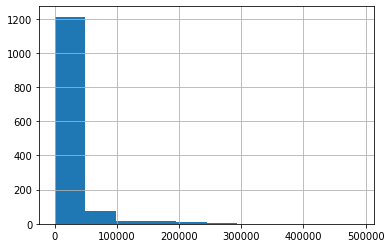

In [128]:
data_full.num_likes.hist()

<AxesSubplot:>

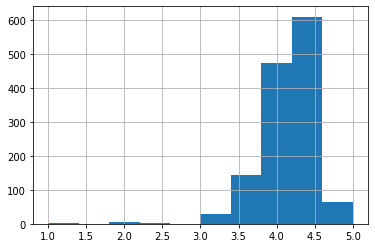

In [129]:
data_full.rating.hist()

<AxesSubplot:>

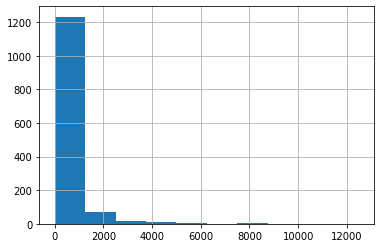

In [130]:
data_full.num_reviews.hist()

<AxesSubplot:>

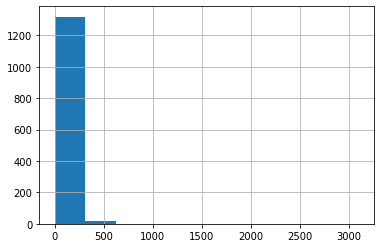

In [131]:
data_full.pricepervol.hist()

In [132]:
data_full.pricepervol.describe()

count    1338.000000
mean       56.955267
std       110.533015
min         1.087500
25%         9.990000
50%        32.941176
75%        72.000000
max      3100.000000
Name: pricepervol, dtype: float64

In [133]:
data_full.loc[data_full.pricepervol>500, ['product_name', 'pricepervol']]

,product_name,pricepervol
63,CLINIQUE Fresh Pressed Renewing Powder Cleanse...,3100.000000
372,BeautyBio R45 The Reversal 3-Phase Retinol Boo...,882.352941
431,AMOREPACIFIC TIME RESPONSE Skin Reserve Serum,560.000000
1248,La Mer The Lifting Eye Serum,550.000000
1254,AMOREPACIFIC TIME RESPONSE Eye Reserve Crème,520.000000
1300,Tata Harper Elixir Vitae Eye Serum,590.000000


In [134]:
#All the products are from premium, luxury brands 
#Only one to correct for error is below.
data_full.loc[data_full.pricepervol==3100, 'pricepervol'] = 31/(28*0.01) 
data_full.loc[data_full.product_name=='BeautyBioR45 The Reversal 3-Phase Retinol Booster System', 'pricepervol'] = 150/(3*0.17)

## 4.0 Cleaning text data

**Steps to clean ingredients:**
1) Remove text from Clean at Sephora

2) Remove text from 'Please be aware that'

3) Remove highlighted ingredients or take the last row or the row itself

4) Add highlighted ingredients to set? 


OR 

Extract the item before 'Clean at Seph' or 'Please be aware that'

In [135]:
data_full.loc[35, 'ingredients']

['Soft Clean Moist Rich Fmg Clns   Division: El (Estee Lauder)Ingredients: Potassium Cocoyl Glycinate , Water , Glycerin , Butylene Glycol , Decyl Glucoside , Potassium Myristoyl Glutamate , Glycol Stearate , Peg-40 Glyceryl Cocoate , Citric Acid , Sodium Pca , Sodium Coceth Sulfate , Fragrance , Passiflora Incarnata Flower Extract , Leontopodium Alpinum Extract , Lythrum Salicaria Extract , Dipotassium Glycyrrhizate , Ethylhexylglycerin , Sodium Hyaluronate , Caffeine , Trehalose , Sucrose , Urea , Caprylyl Glycol , Polyquaternium-51 , Phenoxyethanol ']

In [136]:
def extract_full_ingr(row):
    '''
     
    '''
    ingr=row[len(row)-1]
    for i in range(len(row)):
        #Search for row containing 'Please...' or 'Clean...'
        if ('Please be' in row[i]) or ('Clean at' in row[i]):
            #Check if the row before it is \n. If so, take the item before it. Otherwise, take the row itself
            num=1
            while row[i-num]=='\n' or row[i-num].startswith(('*', '.')):
                num+=1
            else:
                ingr=row[i-num]
                break
        else:
            pass  
    return ingr

In [137]:
data_full['ingr_list']= data_full.ingredients.apply(lambda x: extract_full_ingr(x))

In [138]:
data_full[data_full['ingr_list'].str.startswith('-')].index

Int64Index([ 181,  217,  246,  347,  478,  509,  621,  632,  779,  843,  877,
             892,  898,  903, 1057, 1076, 1110, 1138, 1184],
           dtype='int64')

In [139]:
#Manually changing the entries
data_full.loc[data_full['product_name']=='Kate Somerville +Retinol Vitamin C Moisturizer', 'ingr_list']='Aqua, Neopentyl Glycol Diheptanoate, Caprylic/Capric Triglyceride, Propanediol, Cetearyl Alcohol, Cocoglycerides, Cetyl Esters, Parfum/Fragrance, Stearyl Alcohol, Glyceryl Stearate, Dimethicone, Tridecyl Neopentanoate, PPG-26-Buteth-26, Glycerin, Bis-Stearyl Dimethicone, Retinol, Ascorbic Acid, Tocopheryl Acetate, Panthenol, Physalis Angulata Extract, Volcanic Soil, Tocopherol, Adenosine, Hyaluronic Acid, Ethylhexylglycerin, Amylopectin, PEG-40 Stearate, PEG-40 Hydrogenated Castor Oil, 1,2-Hexanediol, Polyacrylate Crosspolymer-6, Polysorbate 20, Ceteareth-20, Polysilicone-11, Caprylhydroxamic Acid, Arachidyl Alcohol, T-butyl Alcohol, BHA, Citric Acid, Disodium EDTA, Cetyl Alcohol, BHT, Linalool, Limonene'
data_full.loc[data_full['product_name']=='Estée Lauder Micro Essence Skin Activating Treatment Lotion Fresh with Sakura Ferment', 'ingr_list']='Water, Bifida Ferment Lysate, Propanediol, Butylene Glycol, Glycerin, Lactobacillus Ferment, Betaine, Prunus Lannesiana Flower Extract, Anthemis Nobilis (Chamomile) Flower Extract, Laminaria Saccharina Extract, Oryza Sativa (Rice) Lees Extract, Caffeine, Sodium Hyaluronate, Acetyl Hexapeptide-8, Trehalose, Acetyl Glucosamine, Glycine Soja (Soybean) Seed Extract, Caprylyl Glycol, Peg-75, Ppg-5-Ceteth-20, Carbomer, Citric Acid, Pentylene Glycol, Tromethamine, Disodium Edta, Sodium Citrate, Potassium Sorbate, Phenoxyethanol'
data_full.loc[data_full['product_name']=='Kiehl\'s Since 1851 Clearly Corrective™ Brightening and Smoothing Moisture Treatment', 'highlighted_ingr']='White Birch Extract, Glycolic Acid, Activated C'
data_full.loc[data_full['product_name']=='Kiehl\'s Since 1851 Clearly Corrective™ Brightening and Smoothing Moisture Treatment', 'ingr_list']='Water, Dimethicone, Propylene Glycol, Glycerin, Alcohol Denat., Hydroxypropyl, Etrahydropyrantriol, Butylene Glycol, Dimethicone/PEG-10/15 Crosspolymer, 3-O-Ethyl Ascorbic Acid, Paeonia Suffruticosa Root Extract, Potassium Hydroxide, Lavandula Angustifolia Oil/Lavender Oil, Glycolic Acid, Sodium Citrate, Silica, Adenosine, Magnesium Sulfate, Disodium Edta, Dipropylene Glycol, Citric Acid, Citrus Aurantium Tachibana Peel Extract, Tocopherol, Tocopheryl Acetate, Salicylic Acid, Phenoxyethanol, Linalool, Geraniol, Limonene, Citral'
data_full.loc[data_full['product_name']=='Dior Hydra Life Hydration Rescue Intense Sorbet Creme', 'ingr_list']='Mallow Butter, Chamomile Extract, Haberlea, Mallow'
data_full.loc[data_full['product_name']=='LXMI Pure Nilotica Melt Nourishing Balm-to-Oil', 'ingr_list']='Butyrospermum Parkii (Shea Nilotica) Butter'
data_full.loc[data_full['product_name']=='Estée Lauder Micro Essence Skin Activating Treatment Lotion', 'ingr_list']='Corylus Avellana (Hazel) Seed Oil, Pogostemon Cablin Oil, Linalool, Parfum/Fragrance, Limonene, Helianthus Annuus (Sunflower) Seed Oil, Coumarin, Eugenol, Citral, Orchid Extract, Tocopheryl Acetate'
data_full.loc[data_full['product_name']=='Clarins Blue Orchid Face Treatment Oil', 'ingr_list']='Corylus Avellana (Hazel) Seed Oil, Pogostemon Cablin Oil, Linalool, Parfum/Fragrance, Limonene, Helianthus Annuus (Sunflower) Seed Oil, Coumarin, Eugenol, Citral, Orchid Extract, Tocopheryl Acetate'
data_full.loc[data_full['product_name']=='Josie Maran Argan Infinity Cream Intensive Creamy Oil', ['ingr_list']]='Carthamus Tinctorius (Safflower) Seed Oil, Butyrospermum Parkii (Shea) Butter, Coco-Caprylate/Caprate, Cera Alba (Beeswax), Glyceryl Behenate, Citrus Nobilis (Mandarin Orange) Peel Oil, Argania Spinosa (Argan) Kernel Oil, Tocopherol, Crambe Abyssinica (Abyssinian) Seed Oil, Persea Gratissima (Avocado) Oil, Hydrogenated Vegetable Oil, Soybean Glycerides, Glyceryl Linoleate, Aloe Barbadensis (Aloe Vera) Leaf Extract, Mangifera Indica (Mango) Seed Butter, Simmondsia Chinensis (Jojoba) Seed Oil, Aleurites Moluccana Seed (Kukui) Nut Oil, Macadamia Ternifolia (Macadamia) Seed Oil, Tocopherol Acetate'
data_full.loc[data_full['product_name']=='fresh Crème Ancienne® Soft Cream', 'ingr_list']= 'Meadowfoam Seed Oil, Echinacea Extract, Vitamin E, Chamomile Wax'
data_full.loc[data_full.product_name=='Evian Brumisateur® Natural Mineral Water Facial Spray', 'ingr_list']='Pure, Natural evian® Mineral Water'
data_full.loc[data_full.product_name=='Tatcha The Silk Peony Melting Eye Cream', 'ingr_list']='Saccharomyces/Camellia Sinensis Leaf/Cladosiphon Okamuranus/Rice Ferment Filtrate, Aqua/Water/Eau, Glycerin, Squalane, Propanediol, Dimethicone, Behenyl Alcohol, Myristyl Myristate, Glyceryl Stearate SE, Beeswax, Paeonia Albiflora Flower Extract, Hydrolyzed Silk, Sericin, Geranium Robertianum Extract, Chondrus Crispus Extract, Yeast Ferment Extract, Sargassum Vulgare Extract, Sodium Hyaluronate, Inositol, Isostearic Acid, Sodium Stearoyl Glutamate, Silica, Sodium Polyacrylate Starch, Stearyl Alcohol, Caprylic/​Capric/​Myristic/​Stearic Triglyceride, Tocopheryl Acetate, Disodium EDTA, Sodium Acrylate/Acryloyldimethyltaurate/​Dimethylacrylamide Crosspolymer, Caprylyl Glycol, Butylene Glycol, Ethylhexylglycerin, Parfum/Fragrance, Phenoxyethanol, Mica (Ci 77019), Titanium Dioxide (Ci 77891), Tin Oxide (Ci 77861)'
data_full.loc[data_full.product_name=='Clarins Velvet Cleansing Milk', 'ingr_list'] = 'Aqua/Water/Eau, Dicaprylyl Carbonate, Caprylic/ Capric Triglyceride, Glycerin, Propanediol, C14-22 Alcohols, Polysorbate 60, C12-20 Alkyl Glucoside, Parfum/Fragrance, SodiumCitrate, Polyacrylate Crosspolymer-6, Caprylyl Glycol, Citric Acid, Disodium Edta, Ethylhexylglycerin, Xanthan Gum, Melissa Officinalis Leaf Extract, T-Butyl Alcohol, Gentiana Lutea Extract, Maltodextrin, Moringa Oleifera Seed Extract'
data_full.loc[data_full.product_name=='Glow Recipe Avocado Melt Retinol Eye Sleeping Mask', 'ingr_list']='Aqua/Water/Eau, Glycerin, Propanediol, Glyceryl Stearate, Cetearyl Alcohol, Persea Gratissima (Avocado) Oil, C9-12 Alkane, Sodium Lauroyl Glutamate, Stearic Acid, Persea Gratissima (Avocado) Fruit Extract, Squalane, Niacinamide, Ethylhexylglycerin, Hexylresorcinol, Oryza Sativa (Rice) Extract, Tocopheryl Acetate, Aloe Barbadensis Leaf Juice, Coffea Arabica (Coffee) Fruit Extract, Hyaluronic Acid, Ethylhexyl Palmitate, Sodium Hyaluronate, Retinol, PEI-10, Hydrated Silica, Sodium Chloride, Fructan, Maltodextrin, Spirulina Maxima Extract, Curcumin, Butyrospermum Parkii (Shea) Butter, Potassium Chloride, Potassium Phosphate, Butylene Glycol, Sodium Phosphate, Hydrogenated Starch Hydrolysate, Maltooligosyl Glucoside, Arginine, Silica Dimethyl Silylate, Sodium Dilauramidoglutamide Lysine, Sodium Hydroxide, Citric Acid, Caprylyl Glycol, Kaolin, Carthamus Tinctorius (Safflower) Seed Extract, Lavandula Angustifolia (Lavender) Flower/Leaf/Stem Extract, Rosmarinus Officinalis (Rosemary) Leaf Extract, PPG-3 Benzyl Ether Myristate, Polyisobutene, PVP, C13-15 Alkane, Acrylates/C10-30 Alkyl Acrylate Crosspolymer, Sodium Hydroxypropylsulfonate Laurylglucoside Crosspolymer, Hexylene Glycol, Potassium Sorbate, Sodium Benzoate, Phenoxyethanol, Flavor/Aroma'
data_full.loc[data_full.product_name=='belif The True Cream Aqua Bomb', 'ingr_list']='Water, Dipropylene Glycol, Glycerin, Methl Trimethicone, Alcohol Denat, Dimethicone, Cyclopentasiloxane, 1,2-Hexanediol, Malakite Extract, Caprylic/Capric Triglyceride, Pentaerythrityl Tetraethylhexanoate, PEG/PPG/Polybutylene Glycol-8/5/3 Glycerin, Alchemilla Vulgaris Leaf Extract, Equisetum Arvense Leaf Extract, Stellaria Media (Chickweed) Extract, Urtica Dioica (Nettle) Leaf Extract, Plantago Lanceolata Leaf Extract, Avena Sativa (Oat) Kernel Extract, Calendula Officinalis Flower Extract, Nepeta Cataria Extract, Rubus Idaeus (Raspberry) Leaf Extract, Baptisia Tinctoria Root Extract, Dimethiconol, Polymethylsilsesquioxane, Sodium Acrylate/Acryloyldimethyltaurate/Dimethylacrylamide Crosspolymer, Isohexadecane, Polysorbate 60, Ceramide 3, Cholesterol, Butyrospermum Parkii (Shea) Butter, Phenl Trimethicone, Pentaerythrityl Tetraisostearate, Panthenol, Squalane, Triethylhexanoin, Macadamia Ternifolia Seed Oil, PEG-150, PEG-40 Hydrogenated Castor Oil, Acrylates/C10-30 Alkyl Acrylate Crosspolymer, C14-22 Alcohols, Arachidyl Glucoside, Hydrogenated Lecithin, PEG-100 Stearate, Stearic Acid, Glyceryl Stearate, Carbomer, Tromethamine, Trisodium EDTA, Fragrance+, Citronellol, Limonene, Citral, Geraniol, Linalool'
data_full.loc[data_full.product_name=='The Ordinary 100% Plant-Derived Squalane', 'ingr_list']= 'Squalene'
data_full.loc[data_full.product_name=='Tata Harper Concentrated Brightening Serum', 'ingr_list']= 'Hordeum Vulgare Leaf Juice*, Glycerin, Aqua/Water, Rosa Damascena Flower Water*, Caprylic/Capric Triglyceride, Propanediol, Simmondsia Chinensis (Jojoba) Seed Oil, Cetyl Alcohol, Cocos Nucifera (Coconut) Fruit Extract, Lactobacillus Ferment Lysate Filtrate, Arachidyl Alcohol, Helianthus Annuus (Sunflower) Seed Wax, Silybum Marianum (Milk Thistle) Ethyl Ester, Cetearyl Olivate, Glyceryl Stearate SE, Glyceryl Undecylenate, Aroma**, Hydrolyzed Algin, Diglucosyl Gallic Acid, Carthamus Tinctorius (Safflower) Oleosomes*, Hyaluronic Acid, Leontopodium Alpinum Callus Culture Extract, Salix Alba (Willow) Bark Extract, Calcium Ketogluconate, Phoenix Dactylifera (Date) Seed Extract, Menyanthes Trifoliata Leaf Extract, Voandzeia Subterranea Seed Extract, Lavandula Stoechas (Spanish Lavender) Extract, Dunaliella Salince (Algae) Extract, Sodium Hyaluronate, Rosmarinyl Glucoside, Dicrateria Rotunda/Ruttnera Lamellosa Oil, Caffeyl Glucoside, Gallyl Glucoside, Algae Extract, Narcissus Tazetta (Daffodil) Bulb Extract*, Ascophyllum Nodosum Extract, Hippophae Rhamnoides (Sea Buckthorn) Oil*, Opuntia Ficus Indica*, Dictyopteris Membranacea (Sea Fern) Extract, Sambucus Nigra Fruit Extract, Euterpe Oleracea (Acai) Fruit Oil*, Olea Europaea (Olive) Oil*, Pancratium Maritimum Extract, Helianthus Annuus (Sunflower) Seed Oil, Morus Alba Fruit Extract, Sambucus Nigra Fruit Extract, Arnica Montana (Arnica) Extract*, Borago Officinalis (Borage) Leaf Extract*, Calendula Officinalis (Calendula) Flower Extract*, Medicago Sativa (Alfalfa) Extract*, Spiraea Ulmaria (Meadowsweet) Extract*, Centella Asiatica Extract, Lactobacillus Ferment, Squalane, Camellia Sinensis (Green Tea) Seed Oil*, Oenothera Biennis (Evening Primrose) Oil*, Rosa Rubiginosa Seed Oil*, Camellia Oleifera Seed Oil*, Santalum Spicatum (Sandalwood) Seed Oil, Plukenetia Volubilis Seed Oil*, Tocopherol, Sucrose, Lecithin, Sodium Phytate, Behenyl Alcohol, Glyceryl Caprylate, Sorbitan Olivate, Citric Acid, Sodium Citrate, Saccharide Isomerate, Arachidyl Glucoside, Maltodextrin, Acacia Senegal Gum, Xanthan Gum, Benzyl Alcohol, Benzyl Benzoate, Citral, Citronellol, Eugenol, Geraniol, Limonene, Linalool'
data_full.loc[data_full.product_name=='Lord Jones Acid Mantle Repair Moisturizer With 250mg CBD and Ceramides', 'ingr_list']='Water, Helianthus Annuus (Sunflower) Seed Oil, Caprylic/Capric Triglyceride, Cetearyl Alcohol, Glycerin, Squalane, Glyceryl Caprylate, Pentylene Glycol, Hemp Oil, Inula Helenium Extract, Zingiber Officinale (Ginger) Root Extract, Bisabolol, Hyaluronic Acid, Ceramide NP, Ceramide NS, Ceramide AP, Ceramide EOP, Ceramide EOS, Caprooyl Phytosphingosine, Caprooyl Sphingosine, Sodium Stearoyl Glutamate, Glyceryl Stearate Citrate, Quercetin, Ceteareth-25, Behenic Acid, Cetyl Alcohol, Carbomer, Cholesterol, Sodium Hydroxide, Hexylene Glycol, Caprylyl Glycol, Ethylhexylglycerin, Phenoxyethanol'
data_full.loc[data_full.product_name=='Origins GinZing™ Ultra-Hydrating Energy-Boosting Cream', 'ingr_list']='Water, glycerin, caprylic/capric triglyceride, c12-20 acid peg-8 ester, simmondsia chinensis (jojoba) seed oil, caprylic/capric/myristic/stearic triglyceride, hydroxyethyl urea, cetyl alcohol, niacinamide, dimethicone, butylene glycol, sodium polyaspartate, ammonium acryloyldimethyltaurate/vp copolymer, citrus limon (lemon) peel oil, citrus grandis (grapefruit) peel oil, mentha viridis (spearmint) leaf oil, citrus aurantium dulcis (orange) peel oil, limonene, linalool, citral, panax ginseng (ginseng) root extract, hordeum vulgare (barley) extract, salicylic acid, algae extract, linoleic acid, caffeine, sucrose, cucumis sativus (cucumber) fruit extract, trehalose, ophiopogon japonicus root extract, sorbitol, phospholipids, tocopheryl acetate, tocopherol, coffea arabica (coffee) seed oil, arginine, sodium hyaluronate, butyrospermum parkii (shea butter), helianthus annuus (sunflower) seedcake, squalane, ethylhexylglycerin, caprylyl glycol, peg-100 stearate, glyceryl stearate, potassium cetyl phosphate, acrylates/c10-30 alkyl acrylate crosspolymer, behenyl alcohol, xanthan gum, carbomer, sodium hydroxide, disodium edta, chlorphenesin, potassium sorbate, phenoxyethanol, essential oil, organic jojoba oil, organic sucrose (brown sugar)'
data_full.loc[data_full.product_name=='Jack Black Epic Moisture™ MP10™ Nourishing Oil', 'ingr_list']='Cyclopentasiloxane, Dimethiconol, Hydrogenated Ethylhexyl Olivate, Jojoba Esters, C12-15 Alkyl Benzoate, Vitis Vinifera (Grape) Seed Oil, Argania Spinosa (Argan) Kernel Oil, Olea Europaea (Olive) Fruit Oil, Simmondsia Chinensis (Jojoba) Seed Oil, Hydrogenated Olive Oil Unsaponifiables, Oryza Sativa (Rice) Bran Oil, Butyrospermum Parkii (Shea) Butter, Citrillus Ianatus (Watemelon) Seed Oil, Zingiber Officinale (Ginger) Root Extract, Prunus Insititia Seed Oil, Tocopheryl Acetate, Tocopherol, Moringa Oleifera Seed Oil*, Sclerocarya Birrea (Marula) Seed Oil*, Adansonia Digitata (Baobab) Seed Oil*, Fragrance (Parfum), Ascorbyl Palmitate, Retinyl Palmitate, Schinziophyton Rautanenii (Manketti) Kernel Oil*, Carthamus Tinctorius (Safflower) Seed Oil, Citral, Hexyl Cinnamal, Limonene, Linalool'
data_full.loc[data_full.product_name=='fresh Soy Makeup Removing Face Wash', 'ingr_list']='Water, Coco-Glucoside, Glycerin, Butylene Glycol, PEG-7 Glyceryl Cocoate, Xanthan Gum, Glycine Soja (Soybean) Oil, Helianthus Annuus (Sunflower) Seed Oil, Borago Officinalis Seed Oil, Aloe Barbadensis Leaf Juice, Cucumis Sativus (Cucumber) Fruit Extract, Rosa Damascena Extract, Rosa Damascena Flower Water, Centaurea Cyanus Flower Extract, Glycine Soja (Soybean) Sterols, Panax Ginseng Root Extract, Rosa Damascena Flower Oil, Malva Sylvestris (Mallow) Flower Extract, Tocopherol, Ascorbyl Palmitate, PEG-120 Methyl Glucose Dioleate, PEG-40 Hydrogenated Castor Oil, Caprylyl Glycol, Polysorbate 20, Caprylic/Capric Triglyceride, Silica, Benzoic Acid, Disodium EDTA, Citric Acid, Behenyl Alcohol, Glyceryl Stearate, Lecithin, Pentylene Glycol, Hydrolyzed Soy Protein, Caramel, Sodium Benzoate, Potassium Sorbate, Phenoxyethanol'

In [142]:
data_full.loc[data_full['ingr_list'].str.startswith('-'),['product_name', 'ingredients', 'ingr_list', 'highlighted_ingr']]

,product_name,ingredients,ingr_list,highlighted_ingr
181,Dr. Brandt Skincare microdermabrasion age defy...,"[Suggested Usage:, -Dampen skin with warm wate...","-Rinse well, pat dry.","[Aluminum Oxide Crystals, Lactic acid, Jojoba ..."
246,lilah b. Aglow™ Cleansing Butter Mini,"[Suggested Usage:, -Use daily, morning and nig...","-Leave on for up to ten minutes, rinse clean.","[Rose Hip Extract, Snow Mushroom Extract, Lave..."
347,Dr. Brandt Skincare 2% Retinol Complex Serum,[ -Two-Percent Retinol Complex: Improves the l...,-Olive Fruit Extract: Helps reduce the appeara...,"[Two-Percent Retinol Complex, Lemon Tree Honey..."
478,Lord Jones Royal Oil 1000mg Pure CBD Oil,"[ -Broad-spectrum CBD: A restorative, soothing...",-Grape Seed Oil: Rich in antioxidant vitamin E...,"[Broad-spectrum CBD, Grape Seed Oil]"
509,Dr. Jart+ Cicapair™ Tiger Grass Camo Drops SPF 35,"[Suggested Usage:, -After moisturizer, apply t...",-Drops will change from green to beige to even...,"[Herbs Complex and Minerals Solution, Green En..."
621,Tata Harper Boosted Contouring Serum,[-Edelweiss Stem Cells: Support natural skin t...,-Dabberlocks Seaweed: Diminishes the appearanc...,"[Edelweiss Stem Cells, Dabberlocks Seaweed, Ma..."
632,Saint Jane Beauty Luxury CBD Beauty Serum,"[ -Full-spectrum CBD: Nutrient-dense, whole pl...",-Cold-pressed Grapeseed Oil: More powerful tha...,"[Full-spectrum CBD, Potent Botanical Blend, Co..."
779,Tata Harper Concentrated Brightening Essence,[-Caviar Lime: A new generation Alpha Hydroxy ...,-Larch Tree: A natural polysaccharide polymer ...,"[Caviar Lime, Larch Tree, White Mulberry Fruit..."
843,Estée Lauder Resilience Lift Firming/Sculpting...,"[Suggested Usage:, -Apply every morning after ...","-At night, pair with Resilience Lift Night Fir...",[]


In [145]:
#data_full.loc[data_full['product_name']=='', 'ingr_list']
data_full.loc[data_full['product_name']=='lilah b. Aglow™ Cleansing Butter Mini', 'ingr_list']= 'Caprylic/Capric Triglyceride, Polyglyceryl-2 Caprate, Synthetic Wax, Lavandula Angustifolia (Lavender) Oil, Rosa Canina Fruit Extract, Butyrospermum Parkii (Shea) Butter, Water, Saccharomyces/Lithospermum Erythrorhizon Root Oil Ferment Filtrate, Oryza Sativa (Rice) Bran Oil, Pentylene Glycol, Butylene Glycol, Polyglyceryl-2 Sesquioleate, Tocopherol, Tremella Fuciformis Polysaccharide, Linalool'
data_full.loc[data_full['product_name']=='Dr. Brandt Skincare microdermabrasion age defying exfoliator', 'ingr_list']='Water, Alumina, Caprylic/Capric Triglyceride, Glycerin, Cetyl Alcohol, Glyceryl Stearate, Peg-100 Stearate, Ammonium Acryloyldimethyltaurate/Vp Copolymer, Simmondsia Chinensis (Jojoba) Seed Oil, Xanthan Gum, Phenoxyethanol,Lactic Acid, Fragrance (Parfum), Menthone Glycerin Acetal, Allantoin, Disodium Edta, Tocopheryl Acetate, Magnesium Oxide, Propylene Glycol, Aloe Barbadensis Leaf Extract, Vitis Vinifera (Grape) Seed Extract, Chamomilla Recutita (Matricaria) Flower Extract, Camellia Sinensis Leaf Extract, Citral, Limonene'
data_full.loc[data_full['product_name']=='Dr. Brandt Skincare 2% Retinol Complex Serum', 'ingr_list']= 'Water, Glycerin, Dicaprylyl Carbonate, Isoamyl Laurate, Cyclopentasiloxane, Butyrospermum Parkii (Shea) Butter, Shea Butter Cetyl Esters, Triheptanoin, Tocopherol, Phenoxyethanol, Behenyl Alcohol, Methylpropanediol, Glyceryl Stearate Citrate, Polysorbate 20, Sodium Acrylates Copolymer, Retinol, Glyceryl Stearate, Simmondsia Chinensis (Jojoba) Seed Oil, Xanthan Gum, Betaine, Polyglyceryl-3 Stearate, Citrus Paradisi (Grapefruit) Peel Oil, Lavandula Angustifolia (Lavender) Oil, Limonene, Chlorphenesin, Caprylyl Glycol, Caprylic/Capric Triglyceride, Lecithin, Glycine Soja (Soybean) Sterols, Hydrogenated Lecithin, Maslinic Acid, Lysolecithin, Phenylpropanol, BHT, Sodium Phytate, Dimethiconol, Hydrogenated Polyisobutene, Mel (Honey/Miel), Pectin, Phospholipids, Polyglyceryl-10 Stearate, Helianthus Annuus(Sunflower) Seed Oil, Glycine Soja (Soybean) Oil'
data_full.loc[data_full['product_name']=='Lord Jones Royal Oil 1000mg Pure CBD Oil', 'ingr_list']=''
data_full.loc[data_full['product_name']=='Dr. Jart+ Cicapair™ Tiger Grass Camo Drops SPF 35', 'ingr_list']='Aqua, Glycerin, Propanediol, Butylene Glycol, Niacinamide, Dimethicone, 1,2-Hexanediol, Dimethicone/​Vinyl Dimethicone Crosspolymer, Carbomer, Tromethamine, Artemisia Princeps Leaf Extract, Hydroxyacetophenone, Melia Azadirachta Leaf Extract, Cyclopentasiloxane, Glyceryl Polyacrylate, Cyclohexasiloxane, Ethylhexylglycerin, Lecithin, Melia Azadirachta Flower Extract, Octyldodecanol, Adenosine, Disodium EDTA, Theobroma Cacao Extract, Coccinia Indica Fruit Extract, Dextrin, Lavandula Angustifolia Oil, Amber Powder, Polyglutamic Acid, Solanum Melongena Fruit Extract, Citrus Grandis Peel Oil, Limonene, Curcuma Longa Root Extract, Ocimum Sanctum Leaf Extract, Phenoxyethanol, Rosmarinus Officinalis Leaf Oil, Linalool, Corallina Officinalis Extract, Moringa Pterygosperma Seed Oil, Helianthus Annuus Seed Oil, Madecassoside, Anthemis Nobilis Flower Oil, Aniba Rosodora Wood Oil, Centella Asiatica Leaf Water, Houttuynia Cordata Extract, Asiatic Acid, Asiaticoside, Alcohol, Madecassic Acid, Centella Asiatica Leaf Cell Culture Extract, PEG-8, Caprylyl Glycol, Helianthus Annuus Seed Extract, PPG-1-PEG-9 Lauryl Glycol Ether, Achillea Millefolium Extract, Arnica Montana Flower Extract, Artemisia Absinthium Extract, Gentiana Lutea Root Extract, Hedera Helix Leaf/​Stem Extract, Sodium Glycerophosphate, Phytic Acid, Centella Asiatica Extract, Selaginella Lepidophylla Extract, Potassium Magnesium Aspartate, Citric Acid, Sodium Polyacrylate, Potassium Sorbate, Calcium Gluconate, Magnesium Gluconate, Sodium Benzoate, Xanthan Gum, Polysorbate 20'
data_full.loc[data_full['product_name']=='Tata Harper Boosted Contouring Serum', 'ingr_list']= 'Hordeum Vulgare Leaf Juice*, Aqua/Water/Eau, Glycerin, Caprylic / Capric Triglyceride, Rosa Damascena Flower Water*, Propanediol, Cocos Nucifera (Coconut) Fruit Extract, Silybum Marianum (Milk Thistle) Ethyl Ester, Arachidyl Alcohol, Glyceryl Stearate SE, Helianthus Annuus (Sunflower) Seed Wax, Cetearyl Olivate, Cetyl Alcohol, Dipalmitoyl Hydroxyproline, Glyceryl Undecylenate, Algae Extract, Narcissus Tazetta (Daffodil) Bulb Extract*, Hyaluronic Acid, Citrus Aurantium Dulcis (Orange) Flower Extract, Punica Granatum Extract, Carthamus Tinctorius (Safflower) Oleosomes*, Leontopodium Alpinum Callus Culture Extract, Sambucus Nigra Fruit Extract, Calcium Ketogluconate, Phoenix Dactylifera (Date) Seed Extract, Sodium Hyaluronate, Voandzeia Subterranea Seed Extract, Pistacia Lentiscus Gum, Centella Asiatica Extract, Algae Oligosaccharides, Alaria Esculenta Extract, Menyanthes Trifoliata Leaf Extract, Rosmarinyl Glucoside, Lavandula Stoechas (Spanish Lavender) Extract, Caffeyl Glucoside, Gallyl Glucoside, Sorbitan Olivate, Ribose, Rosa Rubiginosa Seed Oil*, Saccharide Isomerate, Arachidyl Glucoside, Salix Alba (Willow) Bark Extract, Glyceryl Caprylate, Helianthus Annuus (Sunflower) Seed Oil, Opuntia Ficus Indica*, Santalum Spicatum (Sandalwood) Seed Oil, Camellia Oleifera Seed Oil*, Camellia Sinensis (Green Tea) Seed Oil*, Euterpe Oleracea (Acai) Fruit Oil*, Plukenetia Volubilis Seed Oil*, Arnica Montana (Arnica) Extract*, Borago Officinalis (Borage) Leaf Extract*, Calendula Officinalis (Calendula) Flower Extract*, Medicago Sativa (Alfalfa) Extract*, Spiraea Ulmaria (Meadowsweet) Extract*, Tocopherol, Olea Europaea (Olive) Oil*, Aroma**, Behenyl Alcohol, Maltodextrin, Xanthan Gum, p-Anisic Acid, Acacia Senegal Gum, Leuconostoc/Radish Root Ferment Filtrate, Citric Acid, Sodium Citrate, Benzyl Alcohol, Benzyl Benzoate, Citral, Citronellol, Eugenol, Geraniol, Limonene, Linalool'
data_full.loc[data_full['product_name']=='Saint Jane Beauty Luxury CBD Beauty Serum', 'ingr_list']='Helianthus Annuus (Sunflower) Seed Oil, Butyrospermum Parkii (Shea) Nut Butter, Punica Granatum (Pomegranate) Seed Extract, Vitus Vinifera (Grape) Seed Oil, Cannabidiol (Full Spectrum CBD), Rosa Canina (Rosehip) Seed Extract, Hippophae Rhamnoides (Seabuckthorn) Fruit Extract, Simmondsia Chinensis (Jojoba) Seed Oil, Rosa Damascena (Rose) Flower Oil, Helichrysum Italicum (Helichrysum) Flower Oil, Cymbopogon Martinii V. Motia (Palmarosa) Leaf Oil, Santalum Spicatum (Sandalwood) Wood Oil, Boswellia Carterii (Frankincense) Resin Extract, Pelargonium Graveolens (Geranium) Leaf/Flower Oil, Commiphora Abyssinica (Myrrh) Resin Extract, Calendula Officinalis (Calendula) Flower Extract, Nardostachys Chinensis (Spikenard) Root Oil, Tocopherol (Vitamin E), Opuntia Ficus-Indica (Prickly Pear) Seed Oil, Rosmarinus Officinalis (Rosemary) Leaf Extract'
data_full.loc[data_full['product_name']=='Tata Harper Concentrated Brightening Essence', 'ingr_list']='Hordeum Vulgare Leaf Juice*, Propanediol, Lavandula Angustifolia (Lavender) Flower/Leaf/Stem Water*, Aqua/Water/Eau, Galactoarabinan, Lactobacillus Ferment Lysate Filtrate, Glycerin, Papain, Microcitrus Australasica Fruit Extract, Salix Alba (Willow) Bark Extract, Glyceryl Caprylate, Leuconostoc Ferment Filtrate, Saccharide Isomerate, Helianthus Annuus (Sunflower) Seed Oil, Sodium Phytate, Tocopherol, Olea Europaea (Olive) Oil*, Hyaluronic Acid, Sodium Hyaluronate, Centella Asiatica Extract, Lactobacillus Ferment, Morus Alba Fruit Extract, Arnica Montana (Arnica) Extract*, Borago Officinalis (Borage) Leaf Extract*, Calendula Officinalis (Calendula) Flower Extract*, Medicago Sativa (Alfalfa) Extract*, Spiraea Ulmaria (Meadowsweet) Extract*, Sambucus Nigra Fruit Extract, Acacia Senegal Gum, Cyamopsis Tetragonoloba (Guar) Gum, Xanthan Gum, Hydrolyzed Rhizobian Gum, Citric Acid, Aroma**, Sodium Citrate, Benzyl Alcohol, Benzyl Benzoate, Citral, Citronellol, Eugenol, Geraniol, Limonene, Linalool'
data_full.loc[data_full['product_name']=='Estée Lauder Resilience Lift Firming/Sculpting Face and Neck Lotion Broad Spectrum SPF 15, Normal/Combination', 'ingr_list']= 'Octinoxate (7.5%), Octisalate (3.5%), Other: Water, Neopentyl Glycol Diheptanoate, Cetyl Alcohol, Pentaerythrityl Tetraethylhexanoate, Glycerin, Polyethylene, Di-C12-15 Alkyl Fumarate, Petrolatum, Hydrolyzed Lecithin, Butylene Glycol, Pentylene Glycol, Octyldodecyl Myristate, Hydrogenated Polyisobutene, Hexyldecyl Stearate, Dimethicone, Laminaria Digitata Extract, Behenyl Alcohol, Potato Starch Modified, Algae Extract, Persea Gratis (Avocado) Oil, Coleus Barbatus Extract, Melon Fruit Extract, Mimosa Tenuiflora Bark Extract, Yeast Extract, Plankton Extract, Aminopropyl Ascorbyl Phosphate, Thermus Thermophillus Ferment Saccharomyces Ferment Lysate Filtrate, Artemia Extract, C12-16 Alcohol, Glyceryl Stearate, Cholesterol/Potassium Sulfate, Octyldodecyl Neopentanoate, Acetyl Glucosamine, Linoleic Acid, Whey Protein, PEG-100 Stearate, Tocopheryl Acetate, Caffeine, Ergothioneine, Soybean Sterols, Palmitic Acid, Polymethyl Methacrylate, Sodium Hyaluronate, Decarboxy Carnosine HCL, Stearic Acid, Potassium Sorbate, Creatine, Zinc PCA, Glucose, Trehalose, Diethylhexyl Syringydenemalonate, Sorbitol, Polysilicone-11, Acetyl Hexapeptide-8, Citric Acid, Lactoperoxidase, Glucose Oxidase, Hydrogenated Starch Hydrolysate, Propylene Glycol Dicaprylate, Caprylic/Capris Triglyceride, Maltodextrin, Malachite, Hexylene Glycol, Ethylhexylglycerin, Phytosterols, Caprylyl Glycol, Sodium Hydroxide, Silica, Aluminum Hydroxide, Fragrance, Xanthan Gum, Disodium EDTA, BHT, Phenoxyethanol, Mica, Titanium Dioxide, Red 4, Yellow 5'

In [156]:
data_full.ingr_list.sample(112)

298     Water, Solum Fullonum (Fuller's\nEarth), Kaoli...
807     Water,\nPropylene Glycol,\nDicaprylyl Ether,\n...
811     Water, Glycerin, Vitis Vinifera (Grape) Seed O...
235     Water, Disodium Laureth Sulfosuccinate, Glycer...
1006     Water, Glycerin, Methyl Trimethicone, Dimethi...
543     Water (Aqua/Eau), Caprylic/Capric Triglyceride...
339      Water, Sodium Hyaluronate, Sodium Acetylated ...
1272    Water Caprylic/Capric Triglyceride, Glycerin, ...
475     Water, Bifida Ferment Lysate, Glycerin, Alcoho...
1228     Water, Methylheptyl Isostearate, Cyclopentasi...
94      Caprylic/Capric Triglyceride, Ethylhexyl Palmi...
878     Aqua/Water/Eau, Glycerin, Mica, Dimethicone, C...
254     Water/Aqua/Edu, Coco Betaine, Coco Glucoside, ...
798       Glycerin, Water, Ricinus Communis (Castor) S...
1018     Water, Helianthus Annuus Seed Oil, Glycerin, ...
1321     Water, Dimethicone, Pentylene Glycol, Sorbito...
43       Water/Aqua, Sodium Cocoyl Isethionate, Coco-G...
468           

Append highlighted ingredients to the full ingredients list 

Remove \n, \t, *

In [163]:
#Append highlighted ingredients to the full list
data_full['highlighted_ingr']=data_full['highlighted_ingr'].apply(lambda x: ', '.join(x))
data_full.ingr_list = data_full.ingr_list+', '+data_full.highlighted_ingr

In [176]:
#Remove \n, \t, *
data_full.ingr_list

0       Opuntia Ficus-Indica (Cactus) Extract, Citrull...
1        Cetyl Ethylhexanoate, Oryza Sativa (Rice) Bra...
2       Aqua, Alumina, Glycerin, Cetearyl Alcohol, Gly...
3       Water, Isohexadecane, Dimethicone, Cyclopentas...
4        Hordeum Vulgare Leaf Juice*, Cetearyl Alcohol...
                              ...                        
1333     Rosa Canina (Rosehip) Fruit Oil*, Helianthus ...
1334    Water/Aqua/Eau, Butylene Glycol, Dimethicone, ...
1335    Water, Butylene Glycol, Glycerin, Caprylic/Cap...
1336     B3Adaptive SuperFoods™ Microcapsule Complex*,...
1337     Aqua (Water), Butylene Glycol, Glycerin, Prop...
Name: ingr_list, Length: 1338, dtype: object

In [184]:
#Remove whitespace characters incl. \n, \t, \r
data_full['ingr_list']=data_full.ingr_list.str.strip()
data_full['ingr_list']= data_full.ingr_list.str.replace('*','', regex=False)

In [214]:
data_full.loc[189, 'ingr_list']

'Aqua/Water/Eau, Stearic Acid, Sodium Cocoyl Glycinate, Lauramidopropyl Betaine, Glycerin, Hydroxypropyl Starch Phosphate, CetearylPhosphate, Xylitylglucoside, Dimethicone PEG-8 Meadowfoamate, Anhydroxylitol, Xylitol, Leuconostoc/Radish Root Ferment Filtrate, Bromelain, Papain, Lactobacillus/Pumpkin Fruit Ferment Filtrate, Lauramide DIPA, Aloe Barbadensis Leaf Juice Powder, Lactic Acid, Glycolic Acid, Citrus Aurantium Bergamia (Bergamot) Fruit Oil, Aniba Rosaeodora (Rosewood) Wood Extract, Citrus Aurantium Dulcis (Orange) Peel Oil, Glucose, Pelargonium Graveolens Flower Oil,Citral, Benzyl Benzoate, Benzyl Alcohol, Sodium Hydroxide, Limonene, Chlorphenesin, Linalool,Citronellol, Maltodextrin, Geraniol,CI 75810(Chlorophyllin-CopperComplex)., Papaya, Pineapple, and Pumpkin Enzymes, Glycolic Acid and Lactic Acid'

In [217]:
data_full.drop(columns=['ingredients'], inplace=True)

In [218]:
#Review before saving
profile=ProfileReport(data_full, title='Profiling Report', explorative=True)
profile.to_widgets()

Summarize dataset:   0%|          | 0/51 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

## 4.0 Creating and saving the final dataset

In [219]:
datapath = '../data/processed_data'
if not os.path.exists(datapath):
    os.mkdir(datapath)
    
datapath_data = os.path.join(datapath, 'combined_data.json')
if not os.path.exists(datapath_data):
    data_full.to_json(datapath_data)

In [220]:
df.reset_index(drop=True, inplace=True)

datapath2 = '../data/raw_data'
if not os.path.exists(datapath2):
    os.mkdir(datapath2)
    
datapath_df = os.path.join(datapath2, 'initial.json')
if not os.path.exists(datapath_df):
    df.to_json(datapath_df)